In [1]:
!pip install Pywavelets

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt
import os
import mne

In [5]:
test_data = pd.read_csv('ExtractedData/Sub. 2/B/datafile002.csv')

In [6]:
ch_names = test_data.columns[:-4].tolist()
ch_names

['Fp1',
 'Fp2',
 'F7',
 'F8',
 'F3',
 'F4',
 'Fz',
 'C3',
 'C4',
 'Cz',
 'P3',
 'P4',
 'Pz',
 'O1',
 'O2',
 'T7',
 'T8',
 'P7',
 'P8',
 'FC1',
 'FC2',
 'FC5',
 'FC6',
 'CP1',
 'CP2',
 'CP5',
 'CP6',
 'POz',
 'Oz',
 'AFz']

In [7]:
data = test_data[ch_names].T.values

info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')

In [8]:
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=30, n_times=10010
    Range : 0 ... 10009 =      0.000 ...    10.009 secs
Ready.


In [9]:
raw.filter(l_freq=1, h_freq=50)
raw.notch_filter(freqs=60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edg

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 30 x 10010 (10.0 s), ~2.3 MB, data loaded>

In [10]:
ica = mne.preprocessing.ICA(n_components=20, random_state=42)

In [11]:
ica.fit(raw)

ica.exclude = ["M1", "M2"]

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 20 components


Fitting ICA took 5.4s.


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_1953/2212592792.py:1: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (6.9e-07) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw)


In [12]:
raw = ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 30 PCA components


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_1953/677053143.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


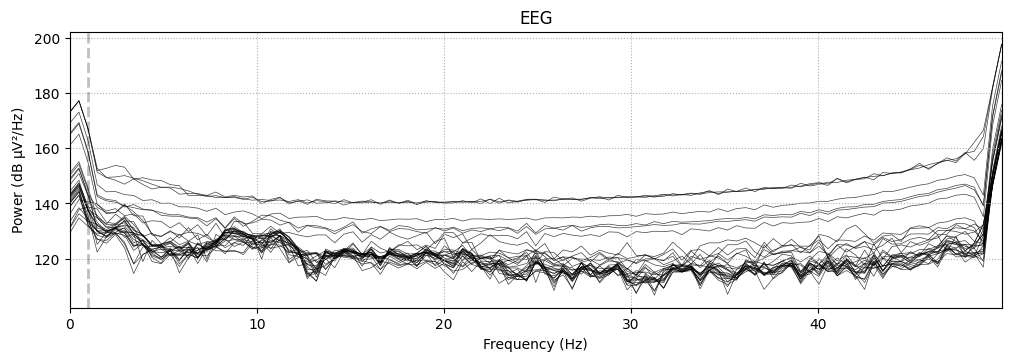

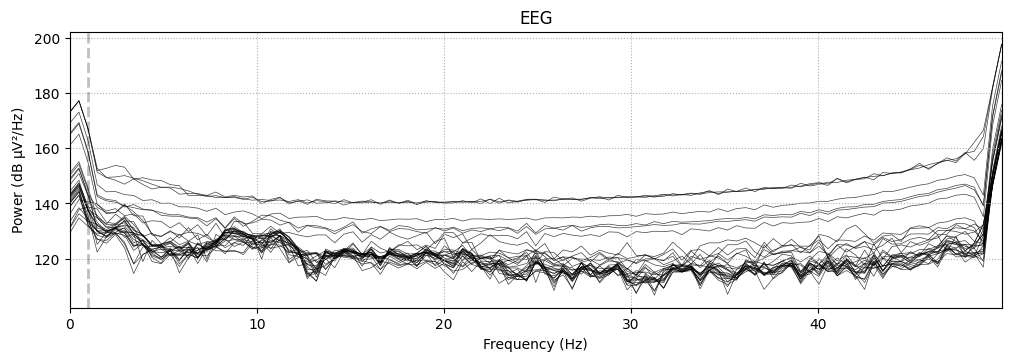

In [13]:
raw.plot_psd(fmax=50)

In [14]:
def preprocess_eeg(df, sfreq=1000):
    # Convert DataFrame to MNE raw object
    ch_names = df.columns[:-2].tolist()  # Exclude 'Sample' and 'Time'
    data = df[ch_names].T.values
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(data, info)

    # Filtering
    raw.filter(l_freq=1, h_freq=50)
    raw.notch_filter(freqs=60)

    # Artifact removal (example using ICA)
    ica = mne.preprocessing.ICA(n_components=20, random_state=97)
    ica.fit(raw)
    ica.exclude = []  # You would typically identify components to exclude here
    raw = ica.apply(raw)

    # Re-referencing to average
    raw.set_eeg_reference('average', projection=True)

    return raw

In [1]:
import os
import numpy as np
import pandas as pd
import mne
import torch
from torch.utils.data import Dataset
from scipy.signal import welch
from multiprocessing import Pool, Manager, cpu_count
import psutil
from tqdm import tqdm
import json
from datetime import datetime


class OlfactoryEEGFeatureDataset(Dataset):
    def __init__(
        self,
        root_dir,
        output_dir,
        sfreq=1000,
        window_size=1000,
        overlap=0.5,
        n_jobs=None,
        batch_size=100,
        memory_threshold=0.8,
        verbose=True
    ):
        """
        Initializes the OlfactoryEEGFeatureDataset.

        Args:
            root_dir (str): Path to the root directory containing raw EEG data.
            output_dir (str): Path to the directory where processed data will be saved.
            sfreq (int, optional): Sampling frequency. Defaults to 1000.
            window_size (int, optional): Size of the window for feature extraction. Defaults to 1000.
            overlap (float, optional): Overlap between windows (0 to 1). Defaults to 0.5.
            n_jobs (int, optional): Number of parallel processes. Defaults to number of CPU cores.
            batch_size (int, optional): Number of samples to process before flushing to disk. Defaults to 100.
            memory_threshold (float, optional): Memory usage threshold to trigger flushing (0 to 1). Defaults to 0.8.
            verbose (bool, optional): Whether to print detailed logs. Defaults to True.
        """
        self.root_dir = root_dir
        self.output_dir = output_dir
        self.sfreq = sfreq
        self.window_size = window_size
        self.overlap = overlap
        self.batch_size = batch_size
        self.memory_threshold = memory_threshold
        self.verbose = verbose

        self.n_jobs = n_jobs if n_jobs is not None else cpu_count()

        # Initialize shared lists for multiprocessing
        manager = Manager()
        self.samples = manager.list()
        self.labels = manager.list()
        self.subject_ids = manager.list()

        # Tracking variables
        self.file_count = 0
        self.progress_file = os.path.join(self.output_dir, 'progress.json')
        self.log_file = os.path.join(self.output_dir, 'processing_log.txt')

        # Create output directory if it doesn't exist
        os.makedirs(self.output_dir, exist_ok=True)

        # Start processing
        self._load_and_extract_features()

    def _load_and_extract_features(self):
        """
        Loads and processes EEG data from all subjects.
        """
        if not os.path.isdir(self.root_dir):
            raise ValueError(f"Root directory '{self.root_dir}' not found")

        subject_folders = [
            folder for folder in os.listdir(self.root_dir) if folder.startswith("Sub.")
        ]

        # Load progress to skip already processed subjects
        processed_subjects = self._load_progress()
        subjects_to_process = [
            subject for subject in subject_folders if subject not in processed_subjects
        ]

        if self.verbose:
            print(f"Starting processing with {self.n_jobs} parallel jobs.")
            print(f"Total subjects to process: {len(subjects_to_process)}")

        with Pool(processes=self.n_jobs) as pool:
            for _ in tqdm(
                pool.imap_unordered(self._process_subject, subjects_to_process),
                total=len(subjects_to_process),
                desc="Processing Subjects"
            ):
                pass
            
        # Final flush of any remaining data
        self._flush_data()

        if self.verbose:
            print("Processing complete.")

    def _process_subject(self, subject_folder):
        """
        Processes all EEG data files for a single subject.

        Args:
            subject_folder (str): Name of the subject folder.
        """
        subject_path = os.path.join(self.root_dir, subject_folder)
        if self.verbose:
            print(f"Processing subject: {subject_folder}")

        for smell_label in 'ABCDEFGHIJKLM':
            smell_path = os.path.join(subject_path, smell_label)
            if os.path.isdir(smell_path):
                if self.verbose:
                    print(f"  Processing smell: {smell_label}")
                for file_name in os.listdir(smell_path):
                    if file_name.startswith("datafile") and file_name.endswith(".csv"):
                        file_path = os.path.join(smell_path, file_name)
                        if self.verbose:
                            print(f"    Processing file: {file_name}")
                        try:
                            features, labels = self._process_file(
                                file_path, smell_label, subject_folder
                            )
                            if features is not None:
                                self.samples.extend(features)
                                self.labels.extend(labels)
                                self.subject_ids.extend([subject_folder] * len(features))

                                # Check memory usage and flush if necessary
                                if (
                                    self._check_memory_usage()
                                    or len(self.samples) >= self.batch_size
                                ):
                                    self._flush_data()

                        except Exception as e:
                            error_message = (
                                f"Error processing {file_path}: {str(e)}"
                            )
                            self._log_error(error_message)
                            if self.verbose:
                                print(error_message)

        # Update progress after processing the subject
        self._update_progress(subject_folder)

    def _process_file(self, file_path, smell_label, subject_folder):
        """
        Processes a single EEG data file.

        Args:
            file_path (str): Path to the EEG data file.
            smell_label (str): Label indicating the smell stimulus.
            subject_folder (str): Subject identifier.

        Returns:
            tuple: Features and labels extracted from the EEG data.
        """
        df = pd.read_csv(file_path)

        if df.empty:
            if self.verbose:
                print(f"    Empty dataframe for file: {file_path}")
            return None, None

        raw = self._preprocess_eeg(df)
        features = self._extract_features(raw)

        labels = [ord(smell_label) - ord('A')] * len(features)
        return features, labels

    def _preprocess_eeg(self, df):
        """
        Preprocesses raw EEG data.

        Args:
            df (pd.DataFrame): Raw EEG data.

        Returns:
            mne.io.Raw: Preprocessed EEG data.
        """
        ch_names = df.columns[:-4].tolist()  # Exclude non-EEG columns
        data = df[ch_names].T.values
        info = mne.create_info(
            ch_names=ch_names, sfreq=self.sfreq, ch_types='eeg'
        )
        raw = mne.io.RawArray(data, info, verbose=False)

        # Bandpass filter
        raw.filter(l_freq=1, h_freq=50, method='iir', verbose=False)
        # Notch filter to remove powerline noise
        raw.notch_filter(freqs=60, method='iir', verbose=False)

        # Independent Component Analysis (ICA) for artifact removal
        ica = mne.preprocessing.ICA(
            n_components=20, random_state=97, max_iter=200, verbose=False
        )
        ica.fit(raw, verbose=False)
        raw = ica.apply(raw, verbose=False)

        # Set average reference
        raw.set_eeg_reference('average', projection=True, verbose=False)
        raw.apply_proj(verbose=False)

        return raw

    def _extract_features(self, raw):
        """
        Extracts statistical and frequency domain features from preprocessed EEG data.

        Args:
            raw (mne.io.Raw): Preprocessed EEG data.

        Returns:
            list: List of feature vectors extracted from EEG data.
        """
        data = raw.get_data()
        windows = self._create_windows(data)

        features = []
        for window in windows:
            # Time-domain features
            mean = np.mean(window, axis=1)
            std = np.std(window, axis=1)

            # Frequency-domain features using Welch's method
            freqs, psd = welch(
                window,
                fs=self.sfreq,
                nperseg=self.window_size,
                axis=1
            )

            # Band power features
            delta_band = self._band_power(psd, freqs, 1, 4)
            theta_band = self._band_power(psd, freqs, 4, 8)
            alpha_band = self._band_power(psd, freqs, 8, 13)
            beta_band = self._band_power(psd, freqs, 13, 30)
            gamma_band = self._band_power(psd, freqs, 30, 50)

            # Concatenate all features
            window_features = np.concatenate([
                mean,
                std,
                delta_band,
                theta_band,
                alpha_band,
                beta_band,
                gamma_band
            ])
            features.append(window_features)

        return features

    def _band_power(self, psd, freqs, fmin, fmax):
        """
        Calculates the average power in a specific frequency band.

        Args:
            psd (ndarray): Power spectral density.
            freqs (ndarray): Frequency values corresponding to PSD.
            fmin (float): Lower frequency bound.
            fmax (float): Upper frequency bound.

        Returns:
            ndarray: Average power in the specified frequency band for each channel.
        """
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        band_power = np.mean(psd[:, freq_mask], axis=1)
        return band_power

    def _create_windows(self, data):
        """
        Creates overlapping windows from EEG data.

        Args:
            data (ndarray): EEG data array of shape (n_channels, n_samples).

        Returns:
            list: List of windowed data arrays.
        """
        step = int(self.window_size * (1 - self.overlap))
        n_samples = data.shape[1]
        windows = [
            data[:, start:start + self.window_size]
            for start in range(0, n_samples - self.window_size + 1, step)
        ]
        return windows

    def _flush_data(self):
        """
        Saves accumulated data to disk and clears the buffers.
        """
        if len(self.samples) == 0:
            return

        samples_array = np.array(self.samples)
        labels_array = np.array(self.labels)
        subject_ids_array = np.array(self.subject_ids)

        # Create a DataFrame for saving
        df = pd.DataFrame(samples_array)
        df['Label'] = labels_array
        df['Subject_ID'] = subject_ids_array

        # Define output file path
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_file = os.path.join(
            self.output_dir,
            f"processed_data_part_{self.file_count}_{timestamp}.csv"
        )

        # Save to CSV
        df.to_csv(output_file, index=False)
        if self.verbose:
            print(f"Saved {len(self.samples)} samples to {output_file}")

        # Clear buffers
        self.samples[:] = []
        self.labels[:] = []
        self.subject_ids[:] = []
        self.file_count += 1

    def _check_memory_usage(self):
        """
        Checks the current memory usage of the system.

        Returns:
            bool: True if memory usage exceeds the threshold, False otherwise.
        """
        memory_usage = psutil.virtual_memory().percent / 100
        return memory_usage >= self.memory_threshold

    def _load_progress(self):
        """
        Loads processing progress from a JSON file.

        Returns:
            list: List of subjects that have been processed.
        """
        if os.path.exists(self.progress_file):
            with open(self.progress_file, 'r') as f:
                processed_subjects = json.load(f)
            return processed_subjects
        return []

    def _update_progress(self, subject):
        """
        Updates the progress file with a newly processed subject.

        Args:
            subject (str): Subject identifier to add to progress.
        """
        processed_subjects = self._load_progress()
        if subject not in processed_subjects:
            processed_subjects.append(subject)
            with open(self.progress_file, 'w') as f:
                json.dump(processed_subjects, f)

    def _log_error(self, message):
        """
        Logs error messages to a log file.

        Args:
            message (str): Error message to log.
        """
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        with open(self.log_file, 'a') as f:
            f.write(f"[{timestamp}] {message}\n")

    def __len__(self):
        """
        Returns:
            int: Total number of samples processed and loaded in memory.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Retrieves a single sample by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (sample_features, label, subject_id)
        """
        sample = torch.FloatTensor(self.samples[idx])
        label = self.labels[idx]
        subject_id = self.subject_ids[idx]
        return sample, label, subject_id



In [2]:
# Usage example:
dataset = OlfactoryEEGFeatureDataset(
    root_dir='ExtractedData',
    output_dir='output',
    sfreq=1000,
    window_size=1000,
    overlap=0.5,
    n_jobs=4,
    batch_size=500,
    memory_threshold=0.75,
    verbose=True
)

Starting processing with 4 parallel jobs.
Total subjects to process: 11


Processing Subjects:   0%|          | 0/11 [00:00<?, ?it/s]

Processing subject: Sub. 10Processing subject: Sub. 11Processing subject: Sub. 2
Processing subject: Sub. 1


  Processing smell: A  Processing smell: A  Processing smell: A
  Processing smell: A


    Processing file: datafile001.csv    Processing file: datafile001.csv    Processing file: datafile001.csv


    Processing file: datafile001.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile002.csv
    Processing file: datafile002.csv    Processing file: datafile002.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv    Processing file: datafile003.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile006.csv    Processing file: datafile006.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile007.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Saved 532 samples to output/processed_data_part_0_20240828_151755.csv
    Processing file: datafile008.csv
Saved 0 samples to output/processed_data_part_0_20240828_151756.csv
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)



    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile011.csv
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwe

    Processing file: datafile012.csv    Processing file: datafile011.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile012.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)



    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile013.csv
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Saved 513 samples to output/processed_data_part_0_20240828_151822.csv
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile016.csv
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv
    Processing file: datafile017.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile019.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile021.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile021.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Saved 513 samples to output/processed_data_part_1_20240828_151851.csv
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (27) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (27) and smallest (2.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile027.csv
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile028.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Saved 513 samples to output/processed_data_part_1_20240828_151917.csv
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile031.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)



    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile032.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)



    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile035.csv    Processing file: datafile034.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


Saved 513 samples to output/processed_data_part_0_20240828_151946.csv
  Processing smell: B
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  Processing smell: B
    Processing file: datafile001.csv
  Processing smell: B
    Processing file: datafile001.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (3.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile002.csv
  Processing smell: B
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
  ica.fit(raw, verbose=False)


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile003.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (5.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile006.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile006.csv
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (27) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile007.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Saved 532 samples to output/processed_data_part_1_20240828_152011.csv
    Processing file: datafile007.csv
Saved 0 samples to output/processed_data_part_2_20240828_152011.csv
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Saved 532 samples to output/processed_data_part_3_20240828_152040.csv
    Processing file: datafile015.csv
Saved 0 samples to output/processed_data_part_2_20240828_152040.csv
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile015.csv
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile018.csv
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile020.csv
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwee

    Processing file: datafile021.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Saved 532 samples to output/processed_data_part_4_20240828_152108.csv
    Processing file: datafile022.csv
Saved 0 samples to output/processed_data_part_3_20240828_152108.csv
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile022.csv
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 1/B/datafile027.csv: Length of values (532) does not match length of index (513)
    Processing file: datafile028.csv
Saved 532 samples to output/processed_data_part_5_20240828_152137.csv
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (27) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile031.csv
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)



    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile032.csv
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (27) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile033.csv    Processing file: datafile033.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwe

    Processing file: datafile032.csv    Processing file: datafile033.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

    Processing file: datafile034.csv
    Processing file: datafile033.csv
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile034.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Saved 513 samples to output/processed_data_part_6_20240828_152202.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

  Processing smell: C
    Processing file: datafile001.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


  Processing smell: C
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


  Processing smell: C
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwe

  Processing smell: C
    Processing file: datafile001.csv
    Processing file: datafile002.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (27) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile002.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)



    Processing file: datafile003.csv
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile004.csv    Processing file: datafile004.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (3.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile005.csv
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile006.csv
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile006.csv
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Saved 513 samples to output/processed_data_part_1_20240828_152228.csv
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile007.csv    Processing file: datafile008.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile010.csv
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile010.csv
    Processing file: datafile011.csv
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile012.csv
    Processing file: datafile011.csv
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv
    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile013.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Saved 551 samples to output/processed_data_part_2_20240828_152256.csv
    Processing file: datafile013.csvError processing ExtractedData/Sub. 1/C/datafile014.csv: Length of values (0) does not match length of index (551)
Error processing ExtractedData/Sub. 2/C/datafile013.csv: Length of values (0) does not match length of index (298)

    Processing file: datafile014.csv    Processing file: datafile014.csv    Processing file: datafile015.csv




/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile015.csv
    Processing file: datafile014.csv    Processing file: datafile015.csv    Processing file: datafile016.csv




/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile015.csv
    Processing file: datafile016.csv
    Processing file: datafile017.csv
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwe

    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile016.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)



    Processing file: datafile017.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

    Processing file: datafile019.csv
    Processing file: datafile018.csv    Processing file: datafile018.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile018.csv
    Processing file: datafile020.csv
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile019.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile021.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwe

Error processing ExtractedData/Sub. 1/C/datafile021.csv: Length of values (551) does not match length of index (532)
    Processing file: datafile022.csv
Saved 551 samples to output/processed_data_part_7_20240828_152325.csv
    Processing file: datafile021.csv
Saved 0 samples to output/processed_data_part_2_20240828_152325.csv
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile022.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile024.csv
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile025.csv
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile026.csv
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/C/datafile027.csv: Length of values (532) does not match length of index (513)Error processing ExtractedData/Sub. 11/C/datafile026.csv: Length of values (532) does not match length of index (513)

    Processing file: datafile028.csv
    Processing file: datafile027.csv
Saved 532 samples to output/processed_data_part_4_20240828_152353.csv
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



    Processing file: datafile032.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)



    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile035.csv
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Saved 532 samples to output/processed_data_part_5_20240828_152423.csv
  Processing smell: D
    Processing file: datafile001.csv
Saved 0 samples to output/processed_data_part_3_20240828_152423.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


  Processing smell: D
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile002.csv
  Processing smell: D
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

  Processing smell: D

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)



    Processing file: datafile001.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv
    Processing file: datafile003.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile003.csv
    Processing file: datafile004.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)



    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)



    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)



    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Saved 551 samples to output/processed_data_part_6_20240828_152452.csv
    Processing file: datafile008.csv
Saved 0 samples to output/processed_data_part_4_20240828_152452.csv
    Processing file: datafile007.csv
Saved 0 samples to output/processed_data_part_8_20240828_152452.csv
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile007.csv
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile008.csv
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

    Processing file: datafile008.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)



    Processing file: datafile010.csv
    Processing file: datafile009.csv    Processing file: datafile010.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile009.csv
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile011.csv
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile010.csv
    Processing file: datafile012.csv
    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Saved 532 samples to output/processed_data_part_7_20240828_152520.csv
    Processing file: datafile015.csv
Saved 0 samples to output/processed_data_part_5_20240828_152520.csv
    Processing file: datafile014.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile019.csv
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile022.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Saved 532 samples to output/processed_data_part_8_20240828_152548.csv
    Processing file: datafile022.csvError processing ExtractedData/Sub. 2/D/datafile022.csv: Length of values (160) does not match length of index (532)

Error processing ExtractedData/Sub. 10/D/datafile020.csv: Length of values (0) does not match length of index (6)
    Processing file: datafile021.csv
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwee

    Processing file: datafile023.csv
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwe

    Processing file: datafile024.csv
    Processing file: datafile023.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (3.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)



    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile025.csv
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 10/D/datafile027.csv: Length of values (532) does not match length of index (513)
    Processing file: datafile028.csv
Saved 532 samples to output/processed_data_part_9_20240828_152618.csv
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


  Processing smell: E

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)



    Processing file: datafile001.csv
  Processing smell: E
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Saved 532 samples to output/processed_data_part_6_20240828_152648.csv
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 1/E/datafile001.csv: Length of values (0) does not match length of index (383)
    Processing file: datafile002.csv
Saved 0 samples to output/processed_data_part_10_20240828_152648.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

  Processing smell: E
    Processing file: datafile003.csv    Processing file: datafile001.csv

    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


  Processing smell: E
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (5.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (5.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (5.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwee

    Processing file: datafile007.csv
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (6.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile008.csv
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Saved 532 samples to output/processed_data_part_9_20240828_152718.csv
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv
Saved 19 samples to output/processed_data_part_7_20240828_152718.csv
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (5.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile008.csv
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile010.csv
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwee

    Processing file: datafile011.csv
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile012.csv    Processing file: datafile012.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (5.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile013.csv
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Saved 532 samples to output/processed_data_part_8_20240828_152748.csv
    Processing file: datafile014.csv
Saved 0 samples to output/processed_data_part_3_20240828_152748.csv
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile018.csv
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile021.csv    Processing file: datafile021.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile022.csv
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile020.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Saved 532 samples to output/processed_data_part_4_20240828_152816.csv
    Processing file: datafile021.csv
Saved 0 samples to output/processed_data_part_9_20240828_152816.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile022.csv
    Processing file: datafile022.csv    Processing file: datafile025.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile023.csv
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile024.csv
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile025.csv
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile026.csv
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile027.csv
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (28) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 10/E/datafile027.csv: Length of values (532) does not match length of index (513)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 2/E/datafile030.csv: Length of values (551) does not match length of index (532)
    Processing file: datafile031.csv
Saved 551 samples to output/processed_data_part_5_20240828_152845.csv
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile029.csv    Processing file: datafile032.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile030.csv
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile031.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)



    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (7.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


  Processing smell: F
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


  Processing smell: F
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (9.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile002.csv
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (3.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Saved 532 samples to output/processed_data_part_10_20240828_152913.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv
Saved 19 samples to output/processed_data_part_11_20240828_152914.csv
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (4.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


  Processing smell: F
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


  Processing smell: F


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile001.csv
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (8.3e-07) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile004.csv
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Saved 532 samples to output/processed_data_part_12_20240828_152943.csv
    Processing file: datafile010.csvError processing ExtractedData/Sub. 11/F/datafile006.csv: Length of values (324) does not match length of index (532)

    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile012.csv
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile013.csv
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (6.6e-07) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Saved 532 samples to output/processed_data_part_13_20240828_153012.csv
    Processing file: datafile017.csvError processing ExtractedData/Sub. 11/F/datafile013.csv: Length of values (0) does not match length of index (508)

    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile017.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile021.csv
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile022.csv
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile020.csv
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

    Processing file: datafile024.csv    Processing file: datafile021.csv

Saved 513 samples to output/processed_data_part_11_20240828_153040.csv
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile026.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)



    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile023.csv
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile027.csv
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile029.csv
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile026.csv
    Processing file: datafile029.csv
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile030.csv
    Processing file: datafile027.csv
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Saved 513 samples to output/processed_data_part_6_20240828_153108.csv
Error processing ExtractedData/Sub. 2/F/datafile030.csv: Length of values (522) does not match length of index (532)    Processing file: datafile028.csv

    Processing file: datafile028.csv    Processing file: datafile032.csv    Processing file: datafile031.csv




/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.99

    Processing file: datafile029.csv
    Processing file: datafile033.csv
    Processing file: datafile032.csv
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile030.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile032.csv
  Processing smell: G
    Processing file: datafile005001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile035.csv
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile005002.csv
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  Processing smell: G
    Processing file: datafile035001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile005003.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



    Processing file: datafile035002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Saved 513 samples to output/processed_data_part_12_20240828_153138.csv
    Processing file: datafile035.csv
    Processing file: datafile005004.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


  Processing smell: G
    Processing file: datafile005005.csv    Processing file: datafile001.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  Processing smell: G
    Processing file: datafile001.csv
    Processing file: datafile035004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile002.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035005.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile003.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile003.csv
    Processing file: datafile035006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile005008.csv
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005009.csv
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005010.csv
Saved 513 samples to output/processed_data_part_13_20240828_153203.csv
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile005015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005016.csv
    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Saved 532 samples to output/processed_data_part_14_20240828_153231.csv
    Processing file: datafile035016.csv
Error processing ExtractedData/Sub. 10/G/datafile012.csv: Length of values (364) does not match length of index (532)
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005018.csv
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005019.csv
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005020.csv
    Processing file: datafile035019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv
    Processing file: datafile005021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005022.csv
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

    Processing file: datafile005023.csv    Processing file: datafile019.csv

    Processing file: datafile035022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/G/datafile019.csv: Length of values (532) does not match length of index (513)
    Processing file: datafile020.csv
Saved 532 samples to output/processed_data_part_15_20240828_153258.csv
    Processing file: datafile035023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile005025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile005026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile022.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile024.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile005030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile005031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Saved 532 samples to output/processed_data_part_14_20240828_153328.csv
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 1/G/datafile005031.csv: Length of values (166) does not match length of index (532)
    Processing file: datafile005032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv
    Processing file: datafile005033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv
    Processing file: datafile005034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile005035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  Processing smell: H
    Processing file: datafile001.csv
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

    Processing file: datafile032.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)



    Processing file: datafile032.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

    Processing file: datafile033.csv
    Processing file: datafile003.csv
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  Processing smell: H
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Saved 532 samples to output/processed_data_part_10_20240828_153359.csv
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Saved 0 samples to output/processed_data_part_7_20240828_153359.csv
    Processing file: datafile034.csv
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile005.csv
    Processing file: datafile003.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  Processing smell: H
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  Processing smell: H
    Processing file: datafile001.csv
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

    Processing file: datafile002.csv    Processing file: datafile005.csv

    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Saved 551 samples to output/processed_data_part_11_20240828_153429.csv
    Processing file: datafile011.csv
Saved 0 samples to output/processed_data_part_16_20240828_153429.csv
    Processing file: datafile009.csvSaved 0 samples to output/processed_data_part_8_20240828_153429.csv

    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile007.csv
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile011.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile015.csv
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 1/H/datafile017.csv: Length of values (570) does not match length of index (513)
    Processing file: datafile018.csv
Saved 570 samples to output/processed_data_part_9_20240828_153459.csv
    Processing file: datafile014.csv
Saved 0 samples to output/processed_data_part_15_20240828_153459.csv
    Processing file: datafile014.csv
Saved 0 samples to output/processed_data_part_17_20240828_153459.csv
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile015.csv
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile018.csv
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile017.csv
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile018.csv
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile019.csv
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv    Processing file: datafile020.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Saved 532 samples to output/processed_data_part_10_20240828_153528.csv
    Processing file: datafile021.csv
Saved 0 samples to output/processed_data_part_16_20240828_153528.csv
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile024.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile027.csv
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Saved 532 samples to output/processed_data_part_12_20240828_153555.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



    Processing file: datafile033.csvError processing ExtractedData/Sub. 11/H/datafile027.csv: Length of values (69) does not match length of index (532)

    Processing file: datafile028.csv
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile029.csv
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)


    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile030.csv    Processing file: datafile035.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

    Processing file: datafile031.csv
  Processing smell: I
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)



    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv
  Processing smell: I
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 2/I/datafile001.csv: Length of values (551) does not match length of index (532)
    Processing file: datafile002.csv
Saved 551 samples to output/processed_data_part_17_20240828_153624.csv
    Processing file: datafile035.csv
Saved 0 samples to output/processed_data_part_11_20240828_153625.csv
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile003.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


  Processing smell: I
    Processing file: datafile001.csv  Processing smell: I

    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile004.csv
    Processing file: datafile002.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)



    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile003.csv
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.99

    Processing file: datafile004.csv
    Processing file: datafile006.csv
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile005.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile006.csv    Processing file: datafile006.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

    Processing file: datafile012.csv
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Saved 513 samples to output/processed_data_part_18_20240828_153655.csv
    Processing file: datafile009.csv    Processing file: datafile007.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile010.csv
    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

    Processing file: datafile011.csv
    Processing file: datafile013.csv
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile012.csv
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile013.csv
    Processing file: datafile015.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/I/datafile015.csv: Length of values (551) does not match length of index (532)
    Processing file: datafile016.csvError processing ExtractedData/Sub. 10/I/datafile013.csv: Length of values (551) does not match length of index (532)
    Processing file: datafile014.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile019.csv: Length of values (570) does not match length of index (551)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/I/datafile014.csv: Length of values (589) does not match length of index (570)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile014.csv: Length of values (608) does not match length of index (589)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/I/datafile016.csv: Length of values (627) does not match length of index (608)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile020.csv: Length of values (646) does not match length of index (627)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/I/datafile015.csv: Length of values (665) does not match length of index (646)
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile015.csv: Length of values (684) does not match length of index (665)
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/I/datafile017.csv: Length of values (703) does not match length of index (684)
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 1/I/datafile021.csv: Length of values (722) does not match length of index (703)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 11/I/datafile016.csv: Length of values (741) does not match length of index (722)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile016.csv: Length of values (760) does not match length of index (741)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/I/datafile018.csv: Length of values (779) does not match length of index (760)
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile022.csv: Length of values (798) does not match length of index (779)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/I/datafile017.csv: Length of values (817) does not match length of index (798)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 10/I/datafile017.csv: Length of values (836) does not match length of index (817)
    Processing file: datafile018.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



Error processing ExtractedData/Sub. 2/I/datafile019.csv: Length of values (855) does not match length of index (836)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile023.csv: Length of values (874) does not match length of index (855)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile018.csv: Length of values (912) does not match length of index (893)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 11/I/datafile018.csv: Length of values (912) does not match length of index (893)
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/I/datafile020.csv: Length of values (931) does not match length of index (912)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile024.csv: Length of values (950) does not match length of index (931)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/I/datafile019.csv: Length of values (1007) does not match length of index (969)
Error processing ExtractedData/Sub. 10/I/datafile019.csv: Length of values (1007) does not match length of index (969)    Processing file: datafile020.csv

    Processing file: datafile020.csv
Error processing ExtractedData/Sub. 2/I/datafile021.csv: Length of values (1007) does not match length of index (988)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile025.csv: Length of values (1026) does not match length of index (1007)
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/I/datafile020.csv: Length of values (1045) does not match length of index (1026)
    Processing file: datafile021.csv
Error processing ExtractedData/Sub. 10/I/datafile020.csv: Length of values (1083) does not match length of index (1064)
Error processing ExtractedData/Sub. 2/I/datafile022.csv: Length of values (1083) does not match length of index (1064)    Processing file: datafile021.csv

    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile026.csv: Length of values (1102) does not match length of index (1083)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/I/datafile021.csv: Length of values (1121) does not match length of index (1102)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile021.csv: Length of values (1159) does not match length of index (1140)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 2/I/datafile023.csv: Length of values (1159) does not match length of index (1140)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile027.csv: Length of values (1178) does not match length of index (1159)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/I/datafile022.csv: Length of values (1197) does not match length of index (1178)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile022.csv: Length of values (1235) does not match length of index (1197)
    Processing file: datafile023.csv
Error processing ExtractedData/Sub. 2/I/datafile024.csv: Length of values (1235) does not match length of index (1216)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile028.csv: Length of values (1254) does not match length of index (1235)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/I/datafile023.csv: Length of values (1273) does not match length of index (1254)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/I/datafile023.csv: Length of values (1311) does not match length of index (1273)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 2/I/datafile025.csv: Length of values (1311) does not match length of index (1292)
    Processing file: datafile026.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/I/datafile029.csv: Length of values (1330) does not match length of index (1311)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 11/I/datafile024.csv: Length of values (1349) does not match length of index (1330)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile024.csv: Length of values (1368) does not match length of index (1349)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 2/I/datafile026.csv: Length of values (1387) does not match length of index (1368)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 11/I/datafile025.csv: Length of values (1425) does not match length of index (1406)Error processing ExtractedData/Sub. 1/I/datafile030.csv: Length of values (1425) does not match length of index (1406)

    Processing file: datafile031.csv    Processing file: datafile026.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile025.csv: Length of values (1463) does not match length of index (1425)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 2/I/datafile027.csv: Length of values (1463) does not match length of index (1444)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 11/I/datafile026.csv: Length of values (1501) does not match length of index (1482)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 1/I/datafile031.csv: Length of values (1501) does not match length of index (1482)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile026.csv: Length of values (1520) does not match length of index (1501)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 2/I/datafile028.csv: Length of values (1539) does not match length of index (1520)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 1/I/datafile032.csv: Length of values (1577) does not match length of index (1558)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 11/I/datafile027.csv: Length of values (1577) does not match length of index (1558)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/I/datafile027.csv: Length of values (1615) does not match length of index (1596)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 2/I/datafile029.csv: Length of values (1615) does not match length of index (1596)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/I/datafile028.csv: Length of values (1634) does not match length of index (1615)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 1/I/datafile033.csv: Length of values (1653) does not match length of index (1634)
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile028.csv: Length of values (1672) does not match length of index (1653)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 2/I/datafile030.csv: Length of values (1691) does not match length of index (1672)
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 1/I/datafile034.csv: Length of values (1729) does not match length of index (1710)
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 11/I/datafile029.csv: Length of values (1729) does not match length of index (1710)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile029.csv: Length of values (1748) does not match length of index (1729)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/I/datafile031.csv: Length of values (1767) does not match length of index (1748)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 1/I/datafile035.csv: Length of values (1805) does not match length of index (1767)
  Processing smell: J
    Processing file: datafile001.csvError processing ExtractedData/Sub. 11/I/datafile030.csv: Length of values (1805) does not match length of index (1786)

    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/I/datafile030.csv: Length of values (1824) does not match length of index (1805)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 2/I/datafile032.csv: Length of values (1843) does not match length of index (1824)
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 11/I/datafile031.csv: Length of values (1881) does not match length of index (1862)Error processing ExtractedData/Sub. 1/J/datafile001.csv: Length of values (1881) does not match length of index (1862)

    Processing file: datafile032.csv    Processing file: datafile002.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/I/datafile033.csv: Length of values (1919) does not match length of index (1900)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 10/I/datafile031.csv: Length of values (1919) does not match length of index (1900)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 11/I/datafile032.csv: Length of values (1976) does not match length of index (1938)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 1/J/datafile002.csv: Length of values (1995) does not match length of index (1938)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 2/I/datafile034.csv: Length of values (1995) does not match length of index (1976)
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 10/I/datafile032.csv: Length of values (1995) does not match length of index (1976)
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 11/I/datafile033.csv: Length of values (2014) does not match length of index (1995)
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/J/datafile003.csv: Length of values (2071) does not match length of index (2033)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 2/I/datafile035.csv: Length of values (2071) does not match length of index (2052)
  Processing smell: J
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 10/I/datafile033.csv: Length of values (2071) does not match length of index (2052)
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/I/datafile034.csv: Length of values (2090) does not match length of index (2071)
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 2/J/datafile001.csv: Length of values (2147) does not match length of index (2109)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 10/I/datafile034.csv: Length of values (2147) does not match length of index (2128)
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 1/J/datafile004.csv: Length of values (2147) does not match length of index (2128)
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/I/datafile035.csv: Length of values (2166) does not match length of index (2147)
  Processing smell: J
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 2/J/datafile002.csv: Length of values (2223) does not match length of index (2204)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 10/I/datafile035.csv: Length of values (2223) does not match length of index (2204)
  Processing smell: J
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 1/J/datafile005.csv: Length of values (2223) does not match length of index (2204)
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/J/datafile001.csv: Length of values (2280) does not match length of index (2223)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 10/J/datafile001.csv: Length of values (2299) does not match length of index (2280)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 2/J/datafile003.csv: Length of values (2299) does not match length of index (2280)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 1/J/datafile006.csv: Length of values (2299) does not match length of index (2280)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 11/J/datafile002.csv: Length of values (2318) does not match length of index (2299)
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/J/datafile004.csv: Length of values (2375) does not match length of index (2356)
    Processing file: datafile005.csv
Error processing ExtractedData/Sub. 10/J/datafile002.csv: Length of values (2375) does not match length of index (2356)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 1/J/datafile007.csv: Length of values (2375) does not match length of index (2356)
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/J/datafile003.csv: Length of values (2394) does not match length of index (2375)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 2/J/datafile005.csv: Length of values (2451) does not match length of index (2432)
    Processing file: datafile006.csv
Error processing ExtractedData/Sub. 10/J/datafile003.csv: Length of values (2451) does not match length of index (2432)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 1/J/datafile008.csv: Length of values (2451) does not match length of index (2432)
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/J/datafile004.csv: Length of values (2470) does not match length of index (2451)
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/J/datafile004.csv: Length of values (2527) does not match length of index (2508)
    Processing file: datafile005.csv
Error processing ExtractedData/Sub. 2/J/datafile006.csv: Length of values (2527) does not match length of index (2508)
    Processing file: datafile007.csv
Error processing ExtractedData/Sub. 1/J/datafile009.csv: Length of values (2527) does not match length of index (2508)
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/J/datafile005.csv: Length of values (2546) does not match length of index (2527)
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/J/datafile005.csv: Length of values (2603) does not match length of index (2584)
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/J/datafile007.csv: Length of values (2603) does not match length of index (2584)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 1/J/datafile010.csv: Length of values (2622) does not match length of index (2584)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 11/J/datafile006.csv: Length of values (2622) does not match length of index (2603)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/J/datafile006.csv: Length of values (2679) does not match length of index (2641)
    Processing file: datafile007.csv
Error processing ExtractedData/Sub. 2/J/datafile008.csv: Length of values (2698) does not match length of index (2660)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 1/J/datafile011.csv: Length of values (2698) does not match length of index (2679)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 11/J/datafile007.csv: Length of values (2698) does not match length of index (2679)
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/J/datafile007.csv: Length of values (2755) does not match length of index (2736)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 2/J/datafile009.csv: Length of values (2755) does not match length of index (2736)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 11/J/datafile008.csv: Length of values (2774) does not match length of index (2755)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 1/J/datafile012.csv: Length of values (2774) does not match length of index (2755)
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/J/datafile008.csv: Length of values (2850) does not match length of index (2793)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 2/J/datafile010.csv: Length of values (2850) does not match length of index (2831)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 11/J/datafile009.csv: Length of values (2850) does not match length of index (2831)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 1/J/datafile013.csv: Length of values (2850) does not match length of index (2831)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 2/J/datafile011.csv: Length of values (2926) does not match length of index (2907)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 11/J/datafile010.csv: Length of values (2926) does not match length of index (2907)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 10/J/datafile009.csv: Length of values (2926) does not match length of index (2907)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 1/J/datafile014.csv: Length of values (2926) does not match length of index (2907)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/J/datafile011.csv: Length of values (3002) does not match length of index (2983)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 2/J/datafile012.csv: Length of values (3002) does not match length of index (2983)
    Processing file: datafile013.csvError processing ExtractedData/Sub. 10/J/datafile010.csv: Length of values (3002) does not match length of index (2983)

    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 1/J/datafile015.csv: Length of values (3002) does not match length of index (2983)
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 1/J/datafile016.csv: Length of values (3078) does not match length of index (3059)
    Processing file: datafile017.csv
Error processing ExtractedData/Sub. 10/J/datafile011.csv: Length of values (3078) does not match length of index (3059)
Error processing ExtractedData/Sub. 11/J/datafile012.csv: Length of values (3078) does not match length of index (3059)
    Processing file: datafile013.csv
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 2/J/datafile013.csv: Length of values (3078) does not match length of index (3059)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 1/J/datafile017.csv: Length of values (3154) does not match length of index (3116)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 10/J/datafile012.csv: Length of values (3154) does not match length of index (3135)
Error processing ExtractedData/Sub. 11/J/datafile013.csv: Length of values (3154) does not match length of index (3135)    Processing file: datafile013.csv

    Processing file: datafile014.csv
Error processing ExtractedData/Sub. 2/J/datafile014.csv: Length of values (3154) does not match length of index (3135)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 1/J/datafile018.csv: Length of values (3192) does not match length of index (3154)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 10/J/datafile013.csv: Length of values (3230) does not match length of index (3211)
    Processing file: datafile014.csv
Error processing ExtractedData/Sub. 2/J/datafile015.csv: Length of values (3230) does not match length of index (3211)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 11/J/datafile014.csv: Length of values (3230) does not match length of index (3211)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 1/J/datafile019.csv: Length of values (3249) does not match length of index (3230)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/J/datafile016.csv: Length of values (3306) does not match length of index (3287)
    Processing file: datafile017.csv
Error processing ExtractedData/Sub. 11/J/datafile015.csv: Length of values (3306) does not match length of index (3287)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 10/J/datafile014.csv: Length of values (3306) does not match length of index (3287)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/J/datafile020.csv: Length of values (3325) does not match length of index (3306)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/J/datafile017.csv: Length of values (3382) does not match length of index (3325)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 10/J/datafile015.csv: Length of values (3382) does not match length of index (3363)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 11/J/datafile016.csv: Length of values (3382) does not match length of index (3363)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/J/datafile021.csv: Length of values (3401) does not match length of index (3382)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/J/datafile016.csv: Length of values (3458) does not match length of index (3439)
    Processing file: datafile017.csv
Error processing ExtractedData/Sub. 2/J/datafile018.csv: Length of values (3458) does not match length of index (3420)
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/J/datafile017.csv: Length of values (3458) does not match length of index (3439)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 1/J/datafile022.csv: Length of values (3477) does not match length of index (3458)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/J/datafile017.csv: Length of values (3534) does not match length of index (3515)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 2/J/datafile019.csv: Length of values (3553) does not match length of index (3515)
    Processing file: datafile020.csv
Error processing ExtractedData/Sub. 11/J/datafile018.csv: Length of values (3553) does not match length of index (3515)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 1/J/datafile023.csv: Length of values (3553) does not match length of index (3534)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 10/J/datafile018.csv: Length of values (3610) does not match length of index (3553)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 11/J/datafile019.csv: Length of values (3629) does not match length of index (3610)Error processing ExtractedData/Sub. 2/J/datafile020.csv: Length of values (3629) does not match length of index (3610)
    Processing file: datafile021.csv

    Processing file: datafile020.csv
Error processing ExtractedData/Sub. 1/J/datafile024.csv: Length of values (3629) does not match length of index (3610)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/J/datafile019.csv: Length of values (3648) does not match length of index (3629)
    Processing file: datafile020.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 2/J/datafile021.csv: Length of values (3705) does not match length of index (3686)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/J/datafile020.csv: Length of values (3705) does not match length of index (3686)
    Processing file: datafile021.csv
Error processing ExtractedData/Sub. 1/J/datafile025.csv: Length of values (3705) does not match length of index (3686)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 10/J/datafile020.csv: Length of values (3724) does not match length of index (3705)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 2/J/datafile022.csv: Length of values (3781) does not match length of index (3743)
    Processing file: datafile023.csv
Error processing ExtractedData/Sub. 11/J/datafile021.csv: Length of values (3800) does not match length of index (3762)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 1/J/datafile026.csv: Length of values (3800) does not match length of index (3781)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/J/datafile021.csv: Length of values (3800) does not match length of index (3781)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/J/datafile023.csv: Length of values (3819) does not match length of index (3800)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/J/datafile022.csv: Length of values (3838) does not match length of index (3819)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/J/datafile027.csv: Length of values (3876) does not match length of index (3838)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 10/J/datafile022.csv: Length of values (3895) does not match length of index (3857)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/J/datafile024.csv: Length of values (3895) does not match length of index (3876)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/J/datafile023.csv: Length of values (3933) does not match length of index (3895)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/J/datafile028.csv: Length of values (3952) does not match length of index (3914)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 10/J/datafile023.csv: Length of values (3971) does not match length of index (3952)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 2/J/datafile025.csv: Length of values (3971) does not match length of index (3952)
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 11/J/datafile024.csv: Length of values (4009) does not match length of index (3990)
    Processing file: datafile025.csv
Error processing ExtractedData/Sub. 1/J/datafile029.csv: Length of values (4047) does not match length of index (4009)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 10/J/datafile024.csv: Length of values (4047) does not match length of index (4028)
    Processing file: datafile025.csv
Error processing ExtractedData/Sub. 2/J/datafile026.csv: Length of values (4047) does not match length of index (4028)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 11/J/datafile025.csv: Length of values (4085) does not match length of index (4047)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 1/J/datafile030.csv: Length of values (4123) does not match length of index (4066)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 2/J/datafile027.csv: Length of values (4123) does not match length of index (4104)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 10/J/datafile025.csv: Length of values (4123) does not match length of index (4104)
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 11/J/datafile026.csv: Length of values (4142) does not match length of index (4123)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/J/datafile031.csv: Length of values (4199) does not match length of index (4161)
    Processing file: datafile032.csv
Error processing ExtractedData/Sub. 2/J/datafile028.csv: Length of values (4199) does not match length of index (4180)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 10/J/datafile026.csv: Length of values (4199) does not match length of index (4180)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 11/J/datafile027.csv: Length of values (4218) does not match length of index (4199)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/J/datafile032.csv: Length of values (4275) does not match length of index (4237)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 2/J/datafile029.csv: Length of values (4275) does not match length of index (4256)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/J/datafile027.csv: Length of values (4275) does not match length of index (4256)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/J/datafile028.csv: Length of values (4294) does not match length of index (4275)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/J/datafile033.csv: Length of values (4351) does not match length of index (4313)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 2/J/datafile030.csv: Length of values (4351) does not match length of index (4332)
    Processing file: datafile031.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/J/datafile028.csv: Length of values (4351) does not match length of index (4332)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 12
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/J/datafile029.csv: Length of values (4389) does not match length of index (4351)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/J/datafile034.csv: Length of values (4408) does not match length of index (4370)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/J/datafile031.csv: Length of values (4427) does not match length of index (4408)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 10/J/datafile029.csv: Length of values (4465) does not match length of index (4408)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/J/datafile030.csv: Length of values (4465) does not match length of index (4446)
Error processing ExtractedData/Sub. 1/J/datafile035.csv: Length of values (4465) does not match length of index (4446)    Processing file: datafile031.csv

  Processing smell: K
    Processing file: datafile005001.csv
Error processing ExtractedData/Sub. 2/J/datafile032.csv: Length of values (4484) does not match length of index (4465)
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/J/datafile030.csv: Length of values (4541) does not match length of index (4484)
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/K/datafile005001.csv: Length of values (4541) does not match length of index (4522)
    Processing file: datafile005002.csv
Error processing ExtractedData/Sub. 11/J/datafile031.csv: Length of values (4560) does not match length of index (4522)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/J/datafile033.csv: Length of values (4560) does not match length of index (4541)
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/J/datafile031.csv: Length of values (4617) does not match length of index (4579)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/K/datafile005002.csv: Length of values (4617) does not match length of index (4598)
    Processing file: datafile005003.csv
Error processing ExtractedData/Sub. 11/J/datafile032.csv: Length of values (4636) does not match length of index (4598)
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/J/datafile034.csv: Length of values (4636) does not match length of index (4617)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/J/datafile032.csv: Length of values (4693) does not match length of index (4636)
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/K/datafile005003.csv: Length of values (4712) does not match length of index (4674)
    Processing file: datafile005004.csv
Error processing ExtractedData/Sub. 11/J/datafile033.csv: Length of values (4712) does not match length of index (4674)
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/J/datafile035.csv: Length of values (4712) does not match length of index (4693)
  Processing smell: K
    Processing file: datafile035001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/J/datafile033.csv: Length of values (4731) does not match length of index (4712)
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 1/K/datafile005004.csv: Length of values (4807) does not match length of index (4769)
    Processing file: datafile005005.csv
Error processing ExtractedData/Sub. 11/J/datafile034.csv: Length of values (4807) does not match length of index (4788)
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 2/K/datafile035001.csv: Length of values (4807) does not match length of index (4788)
    Processing file: datafile035002.csv
Error processing ExtractedData/Sub. 10/J/datafile034.csv: Length of values (4807) does not match length of index (4788)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 1/K/datafile005005.csv: Length of values (4883) does not match length of index (4845)
    Processing file: datafile005006.csv
Error processing ExtractedData/Sub. 11/J/datafile035.csv: Length of values (4883) does not match length of index (4864)
  Processing smell: K
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 2/K/datafile035002.csv: Length of values (4883) does not match length of index (4864)
    Processing file: datafile035003.csv
Error processing ExtractedData/Sub. 10/J/datafile035.csv: Length of values (4883) does not match length of index (4864)
  Processing smell: K
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 1/K/datafile005006.csv: Length of values (4959) does not match length of index (4883)
    Processing file: datafile005007.csv
Error processing ExtractedData/Sub. 10/K/datafile001.csv: Length of values (4959) does not match length of index (4940)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 11/K/datafile001.csv: Length of values (4959) does not match length of index (4940)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 2/K/datafile035003.csv: Length of values (4959) does not match length of index (4940)
    Processing file: datafile035004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 1/K/datafile005007.csv: Length of values (4978) does not match length of index (4959)
    Processing file: datafile005008.csv
Error processing ExtractedData/Sub. 10/K/datafile002.csv: Length of values (5035) does not match length of index (5016)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 11/K/datafile002.csv: Length of values (5035) does not match length of index (5016)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 2/K/datafile035004.csv: Length of values (5035) does not match length of index (5016)
    Processing file: datafile035005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 1/K/datafile005008.csv: Length of values (5073) does not match length of index (5035)
    Processing file: datafile005009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/K/datafile003.csv: Length of values (5111) does not match length of index (5092)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 2/K/datafile035005.csv: Length of values (5111) does not match length of index (5092)
    Processing file: datafile035006.csv
Error processing ExtractedData/Sub. 11/K/datafile003.csv: Length of values (5111) does not match length of index (5092)
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/K/datafile005009.csv: Length of values (5130) does not match length of index (5111)
    Processing file: datafile005010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 10/K/datafile004.csv: Length of values (5187) does not match length of index (5168)
    Processing file: datafile005.csv
Error processing ExtractedData/Sub. 2/K/datafile035006.csv: Length of values (5206) does not match length of index (5187)
    Processing file: datafile035007.csv
Error processing ExtractedData/Sub. 11/K/datafile004.csv: Length of values (5206) does not match length of index (5187)
    Processing file: datafile005.csv
Error processing ExtractedData/Sub. 1/K/datafile005010.csv: Length of values (5206) does not match length of index (5187)
    Processing file: datafile005011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/K/datafile005.csv: Length of values (5282) does not match length of index (5225)
    Processing file: datafile006.csv
Error processing ExtractedData/Sub. 11/K/datafile005.csv: Length of values (5282) does not match length of index (5263)
    Processing file: datafile006.csv
Error processing ExtractedData/Sub. 2/K/datafile035007.csv: Length of values (5282) does not match length of index (5263)
    Processing file: datafile035008.csv
Error processing ExtractedData/Sub. 1/K/datafile005011.csv: Length of values (5282) does not match length of index (5263)
    Processing file: datafile005012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 10/K/datafile006.csv: Length of values (5320) does not match length of index (5301)
    Processing file: datafile007.csv
Error processing ExtractedData/Sub. 11/K/datafile006.csv: Length of values (5358) does not match length of index (5320)
    Processing file: datafile007.csv
Error processing ExtractedData/Sub. 2/K/datafile035008.csv: Length of values (5358) does not match length of index (5339)
    Processing file: datafile035009.csv
Error processing ExtractedData/Sub. 1/K/datafile005012.csv: Length of values (5358) does not match length of index (5339)
    Processing file: datafile005013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 10/K/datafile007.csv: Length of values (5434) does not match length of index (5377)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 11/K/datafile007.csv: Length of values (5434) does not match length of index (5396)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 2/K/datafile035009.csv: Length of values (5434) does not match length of index (5415)
    Processing file: datafile035010.csv
Error processing ExtractedData/Sub. 1/K/datafile005013.csv: Length of values (5434) does not match length of index (5415)
    Processing file: datafile005014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/K/datafile008.csv: Length of values (5510) does not match length of index (5453)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 10/K/datafile008.csv: Length of values (5510) does not match length of index (5453)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 1/K/datafile005014.csv: Length of values (5510) does not match length of index (5491)
    Processing file: datafile005015.csv
Error processing ExtractedData/Sub. 2/K/datafile035010.csv: Length of values (5510) does not match length of index (5491)
    Processing file: datafile035011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/K/datafile009.csv: Length of values (5548) does not match length of index (5529)
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/K/datafile009.csv: Length of values (5586) does not match length of index (5529)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 1/K/datafile005015.csv: Length of values (5605) does not match length of index (5586)
    Processing file: datafile005016.csv
Error processing ExtractedData/Sub. 2/K/datafile035011.csv: Length of values (5605) does not match length of index (5586)
    Processing file: datafile035012.csv
Error processing ExtractedData/Sub. 11/K/datafile010.csv: Length of values (5605) does not match length of index (5586)
    Processing file: datafile011.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/K/datafile010.csv: Length of values (5662) does not match length of index (5605)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 1/K/datafile005016.csv: Length of values (5681) does not match length of index (5662)
    Processing file: datafile005017.csv
Error processing ExtractedData/Sub. 2/K/datafile035012.csv: Length of values (5681) does not match length of index (5662)
    Processing file: datafile035013.csv
Error processing ExtractedData/Sub. 11/K/datafile011.csv: Length of values (5681) does not match length of index (5662)
    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/K/datafile011.csv: Length of values (5757) does not match length of index (5700)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 1/K/datafile005017.csv: Length of values (5757) does not match length of index (5738)
    Processing file: datafile005018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/K/datafile035013.csv: Length of values (5757) does not match length of index (5738)
    Processing file: datafile035014.csv
Error processing ExtractedData/Sub. 11/K/datafile012.csv: Length of values (5757) does not match length of index (5738)
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/K/datafile012.csv: Length of values (5795) does not match length of index (5757)
    Processing file: datafile013.csv
Error processing ExtractedData/Sub. 1/K/datafile005018.csv: Length of values (5833) does not match length of index (5814)
    Processing file: datafile005019.csv
Error processing ExtractedData/Sub. 11/K/datafile013.csv: Length of values (5833) does not match length of index (5814)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/K/datafile035014.csv: Length of values (5833) does not match length of index (5814)
    Processing file: datafile035015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/K/datafile013.csv: Length of values (5871) does not match length of index (5833)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/K/datafile005019.csv: Length of values (5909) does not match length of index (5871)
    Processing file: datafile005020.csv
Error processing ExtractedData/Sub. 11/K/datafile014.csv: Length of values (5909) does not match length of index (5890)
    Processing file: datafile015.csv
Error processing ExtractedData/Sub. 2/K/datafile035015.csv: Length of values (5928) does not match length of index (5909)
    Processing file: datafile035016.csv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/K/datafile014.csv: Length of values (5928) does not match length of index (5909)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/K/datafile005020.csv: Length of values (5947) does not match length of index (5928)
    Processing file: datafile005021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 11/K/datafile015.csv: Length of values (6023) does not match length of index (5985)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 2/K/datafile035016.csv: Length of values (6023) does not match length of index (6004)
Error processing ExtractedData/Sub. 10/K/datafile015.csv: Length of values (6023) does not match length of index (6004)    Processing file: datafile035017.csv

    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 1/K/datafile005021.csv: Length of values (6023) does not match length of index (6004)
    Processing file: datafile005022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance o

Error processing ExtractedData/Sub. 11/K/datafile016.csv: Length of values (6099) does not match length of index (6061)
    Processing file: datafile017.csv
Error processing ExtractedData/Sub. 2/K/datafile035017.csv: Length of values (6099) does not match length of index (6061)
    Processing file: datafile035018.csv
Error processing ExtractedData/Sub. 10/K/datafile016.csv: Length of values (6099) does not match length of index (6080)
    Processing file: datafile017.csv
Error processing ExtractedData/Sub. 1/K/datafile005022.csv: Length of values (6099) does not match length of index (6080)
    Processing file: datafile005023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/K/datafile017.csv: Length of values (6175) does not match length of index (6156)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 2/K/datafile035018.csv: Length of values (6175) does not match length of index (6156)
    Processing file: datafile035019.csv
Error processing ExtractedData/Sub. 1/K/datafile005023.csv: Length of values (6175) does not match length of index (6156)
    Processing file: datafile005024.csv
Error processing ExtractedData/Sub. 10/K/datafile017.csv: Length of values (6175) does not match length of index (6156)
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/K/datafile018.csv: Length of values (6213) does not match length of index (6175)
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/K/datafile018.csv: Length of values (6251) does not match length of index (6232)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 1/K/datafile005024.csv: Length of values (6251) does not match length of index (6232)
    Processing file: datafile005025.csv
Error processing ExtractedData/Sub. 2/K/datafile035019.csv: Length of values (6251) does not match length of index (6232)
    Processing file: datafile035020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/K/datafile019.csv: Length of values (6270) does not match length of index (6251)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/K/datafile019.csv: Length of values (6327) does not match length of index (6308)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/K/datafile005025.csv: Length of values (6327) does not match length of index (6308)
    Processing file: datafile005026.csv
Error processing ExtractedData/Sub. 2/K/datafile035020.csv: Length of values (6327) does not match length of index (6308)
    Processing file: datafile035021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/K/datafile020.csv: Length of values (6346) does not match length of index (6327)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/K/datafile020.csv: Length of values (6422) does not match length of index (6384)
    Processing file: datafile021.csv
Error processing ExtractedData/Sub. 2/K/datafile035021.csv: Length of values (6422) does not match length of index (6403)
    Processing file: datafile035022.csv
Error processing ExtractedData/Sub. 1/K/datafile005026.csv: Length of values (6422) does not match length of index (6384)
    Processing file: datafile005027.csv
Error processing ExtractedData/Sub. 11/K/datafile021.csv: Length of values (6422) does not match length of index (6403)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/K/datafile021.csv: Length of values (6498) does not match length of index (6422)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 2/K/datafile035022.csv: Length of values (6498) does not match length of index (6479)
    Processing file: datafile035023.csv
Error processing ExtractedData/Sub. 1/K/datafile005027.csv: Length of values (6498) does not match length of index (6479)
    Processing file: datafile005028.csv
Error processing ExtractedData/Sub. 11/K/datafile022.csv: Length of values (6498) does not match length of index (6479)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/K/datafile022.csv: Length of values (6555) does not match length of index (6498)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/K/datafile035023.csv: Length of values (6574) does not match length of index (6555)
    Processing file: datafile035024.csv
Error processing ExtractedData/Sub. 1/K/datafile005028.csv: Length of values (6593) does not match length of index (6555)
    Processing file: datafile005029.csv
Error processing ExtractedData/Sub. 11/K/datafile023.csv: Length of values (6593) does not match length of index (6555)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 10/K/datafile023.csv: Length of values (6593) does not match length of index (6574)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 2/K/datafile035024.csv: Length of values (6650) does not match length of index (6593)
    Processing file: datafile035025.csv
Error processing ExtractedData/Sub. 1/K/datafile005029.csv: Length of values (6669) does not match length of index (6631)
    Processing file: datafile005030.csv
Error processing ExtractedData/Sub. 11/K/datafile024.csv: Length of values (6669) does not match length of index (6650)
    Processing file: datafile025.csv
Error processing ExtractedData/Sub. 10/K/datafile024.csv: Length of values (6669) does not match length of index (6650)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 2/K/datafile035025.csv: Length of values (6745) does not match length of index (6669)
    Processing file: datafile035026.csv
Error processing ExtractedData/Sub. 11/K/datafile025.csv: Length of values (6745) does not match length of index (6726)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 1/K/datafile005030.csv: Length of values (6745) does not match length of index (6726)
    Processing file: datafile005031.csv
Error processing ExtractedData/Sub. 10/K/datafile025.csv: Length of values (6745) does not match length of index (6726)
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 2/K/datafile035026.csv: Length of values (6821) does not match length of index (6764)
    Processing file: datafile035027.csv
Error processing ExtractedData/Sub. 11/K/datafile026.csv: Length of values (6821) does not match length of index (6802)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/K/datafile005031.csv: Length of values (6821) does not match length of index (6802)
    Processing file: datafile005032.csv
Error processing ExtractedData/Sub. 10/K/datafile026.csv: Length of values (6821) does not match length of index (6802)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 2/K/datafile035027.csv: Length of values (6897) does not match length of index (6821)
    Processing file: datafile035028.csv
Error processing ExtractedData/Sub. 11/K/datafile027.csv: Length of values (6897) does not match length of index (6878)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 1/K/datafile005032.csv: Length of values (6897) does not match length of index (6878)
    Processing file: datafile005033.csv
Error processing ExtractedData/Sub. 10/K/datafile027.csv: Length of values (6897) does not match length of index (6878)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 2/K/datafile035028.csv: Length of values (6973) does not match length of index (6897)
    Processing file: datafile035029.csv
Error processing ExtractedData/Sub. 10/K/datafile028.csv: Length of values (6973) does not match length of index (6954)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 1/K/datafile005033.csv: Length of values (6973) does not match length of index (6954)
    Processing file: datafile005034.csv
Error processing ExtractedData/Sub. 11/K/datafile028.csv: Length of values (6973) does not match length of index (6954)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 2/K/datafile035029.csv: Length of values (7011) does not match length of index (6973)
    Processing file: datafile035030.csv
Error processing ExtractedData/Sub. 10/K/datafile029.csv: Length of values (7049) does not match length of index (7030)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/K/datafile029.csv: Length of values (7049) does not match length of index (7030)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 1/K/datafile005034.csv: Length of values (7049) does not match length of index (7030)
    Processing file: datafile005035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/K/datafile035030.csv: Length of values (7068) does not match length of index (7049)
    Processing file: datafile035031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 6
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwee

Error processing ExtractedData/Sub. 10/K/datafile030.csv: Length of values (7144) does not match length of index (7106)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 1/K/datafile005035.csv: Length of values (7144) does not match length of index (7106)
  Processing smell: L
    Processing file: datafile005001.csv
Error processing ExtractedData/Sub. 11/K/datafile030.csv: Length of values (7144) does not match length of index (7106)
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/K/datafile035031.csv: Length of values (7144) does not match length of index (7125)
    Processing file: datafile035032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 10/K/datafile031.csv: Length of values (7201) does not match length of index (7182)
    Processing file: datafile032.csv
Error processing ExtractedData/Sub. 1/L/datafile005001.csv: Length of values (7201) does not match length of index (7182)
    Processing file: datafile005002.csv
Error processing ExtractedData/Sub. 11/K/datafile031.csv: Length of values (7201) does not match length of index (7182)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 2/K/datafile035032.csv: Length of values (7239) does not match length of index (7201)
    Processing file: datafile035033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/K/datafile032.csv: Length of values (7277) does not match length of index (7258)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 1/L/datafile005002.csv: Length of values (7296) does not match length of index (7258)
    Processing file: datafile005003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/K/datafile032.csv: Length of values (7296) does not match length of index (7258)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 2/K/datafile035033.csv: Length of values (7315) does not match length of index (7277)
    Processing file: datafile035034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/K/datafile033.csv: Length of values (7353) does not match length of index (7296)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 1/L/datafile005003.csv: Length of values (7372) does not match length of index (7353)
    Processing file: datafile005004.csv
Error processing ExtractedData/Sub. 11/K/datafile033.csv: Length of values (7372) does not match length of index (7353)
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/K/datafile035034.csv: Length of values (7372) does not match length of index (7353)
    Processing file: datafile035035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/K/datafile034.csv: Length of values (7429) does not match length of index (7372)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/L/datafile005004.csv: Length of values (7448) does not match length of index (7410)
    Processing file: datafile005005.csv
Error processing ExtractedData/Sub. 11/K/datafile034.csv: Length of values (7448) does not match length of index (7429)
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 2/K/datafile035035.csv: Length of values (7467) does not match length of index (7429)
  Processing smell: L
    Processing file: datafile035001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/K/datafile035.csv: Length of values (7486) does not match length of index (7448)
  Processing smell: L
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/L/datafile005005.csv: Length of values (7524) does not match length of index (7505)
    Processing file: datafile005006.csv
Error processing ExtractedData/Sub. 11/K/datafile035.csv: Length of values (7524) does not match length of index (7505)
  Processing smell: L
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 2/L/datafile035001.csv: Length of values (7543) does not match length of index (7505)
    Processing file: datafile035002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/L/datafile001.csv: Length of values (7543) does not match length of index (7524)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/L/datafile005006.csv: Length of values (7619) does not match length of index (7581)
    Processing file: datafile005007.csv
Error processing ExtractedData/Sub. 11/L/datafile001.csv: Length of values (7619) does not match length of index (7581)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 2/L/datafile035002.csv: Length of values (7619) does not match length of index (7600)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile035003.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile002.csv: Length of values (7619) does not match length of index (7600)
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile002.csv: Length of values (7695) does not match length of index (7638)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 1/L/datafile005007.csv: Length of values (7695) does not match length of index (7638)
    Processing file: datafile005008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 10/L/datafile003.csv: Length of values (7695) does not match length of index (7676)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 2/L/datafile035003.csv: Length of values (7695) does not match length of index (7676)
    Processing file: datafile035004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile003.csv: Length of values (7733) does not match length of index (7714)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 1/L/datafile005008.csv: Length of values (7752) does not match length of index (7714)
    Processing file: datafile005009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/L/datafile035004.csv: Length of values (7771) does not match length of index (7752)
    Processing file: datafile035005.csvError processing ExtractedData/Sub. 10/L/datafile004.csv: Length of values (7771) does not match length of index (7752)

    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 1/L/datafile005009.csv: Length of values (7847) does not match length of index (7790)
    Processing file: datafile005010.csv
Error processing ExtractedData/Sub. 11/L/datafile004.csv: Length of values (7847) does not match length of index (7790)
    Processing file: datafile005.csv
Error processing ExtractedData/Sub. 10/L/datafile005.csv: Length of values (7847) does not match length of index (7828)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile006.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)



Error processing ExtractedData/Sub. 2/L/datafile035005.csv: Length of values (7847) does not match length of index (7828)
    Processing file: datafile035006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/L/datafile005010.csv: Length of values (7904) does not match length of index (7866)
    Processing file: datafile005011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile005.csv: Length of values (7904) does not match length of index (7885)
    Processing file: datafile006.csv
Error processing ExtractedData/Sub. 10/L/datafile006.csv: Length of values (7923) does not match length of index (7904)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 2/L/datafile035006.csv: Length of values (7942) does not match length of index (7904)
    Processing file: datafile035007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/L/datafile005011.csv: Length of values (7980) does not match length of index (7961)
    Processing file: datafile005012.csv
Error processing ExtractedData/Sub. 11/L/datafile006.csv: Length of values (7999) does not match length of index (7961)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile007.csv: Length of values (7999) does not match length of index (7980)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 2/L/datafile035007.csv: Length of values (8018) does not match length of index (7980)
    Processing file: datafile035008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/L/datafile005012.csv: Length of values (8037) does not match length of index (7999)
    Processing file: datafile005013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/L/datafile007.csv: Length of values (8075) does not match length of index (8037)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 10/L/datafile008.csv: Length of values (8094) does not match length of index (8056)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 2/L/datafile035008.csv: Length of values (8094) does not match length of index (8056)
    Processing file: datafile035009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/L/datafile005013.csv: Length of values (8113) does not match length of index (8075)
    Processing file: datafile005014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 11/L/datafile008.csv: Length of values (8151) does not match length of index (8132)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 2/L/datafile035009.csv: Length of values (8170) does not match length of index (8132)
    Processing file: datafile035010.csv
Error processing ExtractedData/Sub. 10/L/datafile009.csv: Length of values (8170) does not match length of index (8132)
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/L/datafile005014.csv: Length of values (8170) does not match length of index (8151)
    Processing file: datafile005015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 11/L/datafile009.csv: Length of values (8246) does not match length of index (8189)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 2/L/datafile035010.csv: Length of values (8246) does not match length of index (8227)
    Processing file: datafile035011.csv
Error processing ExtractedData/Sub. 10/L/datafile010.csv: Length of values (8246) does not match length of index (8227)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 1/L/datafile005015.csv: Length of values (8246) does not match length of index (8227)
    Processing file: datafile005016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/L/datafile010.csv: Length of values (8322) does not match length of index (8303)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 2/L/datafile035011.csv: Length of values (8322) does not match length of index (8303)
    Processing file: datafile035012.csv
Error processing ExtractedData/Sub. 10/L/datafile011.csv: Length of values (8322) does not match length of index (8303)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 1/L/datafile005016.csv: Length of values (8322) does not match length of index (8303)
    Processing file: datafile005017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/L/datafile011.csv: Length of values (8398) does not match length of index (8379)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 2/L/datafile035012.csv: Length of values (8398) does not match length of index (8379)
    Processing file: datafile035013.csv
Error processing ExtractedData/Sub. 1/L/datafile005017.csv: Length of values (8398) does not match length of index (8379)
    Processing file: datafile005018.csv
Error processing ExtractedData/Sub. 10/L/datafile012.csv: Length of values (8398) does not match length of index (8379)
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw, verbose=False)
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/skle

Error processing ExtractedData/Sub. 11/L/datafile012.csv: Length of values (8474) does not match length of index (8417)
    Processing file: datafile013.csv
Error processing ExtractedData/Sub. 1/L/datafile005018.csv: Length of values (8474) does not match length of index (8455)
    Processing file: datafile005019.csv
Error processing ExtractedData/Sub. 10/L/datafile013.csv: Length of values (8474) does not match length of index (8455)
    Processing file: datafile014.csv
Error processing ExtractedData/Sub. 2/L/datafile035013.csv: Length of values (8474) does not match length of index (8455)
    Processing file: datafile035014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 11/L/datafile013.csv: Length of values (8550) does not match length of index (8493)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/L/datafile005019.csv: Length of values (8550) does not match length of index (8531)
    Processing file: datafile005020.csv
Error processing ExtractedData/Sub. 2/L/datafile035014.csv: Length of values (8550) does not match length of index (8531)
    Processing file: datafile035015.csv
Error processing ExtractedData/Sub. 10/L/datafile014.csv: Length of values (8550) does not match length of index (8531)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 11/L/datafile014.csv: Length of values (8588) does not match length of index (8569)
    Processing file: datafile015.csv
Error processing ExtractedData/Sub. 1/L/datafile005020.csv: Length of values (8607) does not match length of index (8569)
    Processing file: datafile005021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 2/L/datafile035015.csv: Length of values (8645) does not match length of index (8607)
    Processing file: datafile035016.csv
Error processing ExtractedData/Sub. 10/L/datafile015.csv: Length of values (8645) does not match length of index (8626)
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile015.csv: Length of values (8664) does not match length of index (8645)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 1/L/datafile005021.csv: Length of values (8702) does not match length of index (8645)
    Processing file: datafile005022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/L/datafile035016.csv: Length of values (8702) does not match length of index (8683)
    Processing file: datafile035017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile016.csv: Length of values (8721) does not match length of index (8683)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile016.csv: Length of values (8740) does not match length of index (8721)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/L/datafile005022.csv: Length of values (8778) does not match length of index (8740)
    Processing file: datafile005023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 2/L/datafile035017.csv: Length of values (8778) does not match length of index (8759)
    Processing file: datafile035018.csv
Error processing ExtractedData/Sub. 10/L/datafile017.csv: Length of values (8797) does not match length of index (8759)
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile017.csv: Length of values (8816) does not match length of index (8797)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 1/L/datafile005023.csv: Length of values (8816) does not match length of index (8797)
    Processing file: datafile005024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/L/datafile018.csv: Length of values (8854) does not match length of index (8835)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 2/L/datafile035018.csv: Length of values (8854) does not match length of index (8835)
    Processing file: datafile035019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile018.csv: Length of values (8892) does not match length of index (8873)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 1/L/datafile005024.csv: Length of values (8930) does not match length of index (8892)
    Processing file: datafile005025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/L/datafile035019.csv: Length of values (8930) does not match length of index (8911)
    Processing file: datafile035020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile019.csv: Length of values (8930) does not match length of index (8911)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile019.csv: Length of values (8968) does not match length of index (8949)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/L/datafile005025.csv: Length of values (9006) does not match length of index (8968)
    Processing file: datafile005026.csv
Error processing ExtractedData/Sub. 2/L/datafile035020.csv: Length of values (9025) does not match length of index (8987)
    Processing file: datafile035021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile020.csv: Length of values (9025) does not match length of index (9006)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile020.csv: Length of values (9044) does not match length of index (9006)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/L/datafile005026.csv: Length of values (9082) does not match length of index (9044)
    Processing file: datafile005027.csv
Error processing ExtractedData/Sub. 2/L/datafile035021.csv: Length of values (9101) does not match length of index (9063)
    Processing file: datafile035022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile021.csv: Length of values (9101) does not match length of index (9082)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 11/L/datafile021.csv: Length of values (9120) does not match length of index (9082)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 1/L/datafile005027.csv: Length of values (9158) does not match length of index (9120)
    Processing file: datafile005028.csv
Error processing ExtractedData/Sub. 2/L/datafile035022.csv: Length of values (9177) does not match length of index (9139)
    Processing file: datafile035023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile022.csv: Length of values (9177) does not match length of index (9158)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile022.csv: Length of values (9196) does not match length of index (9177)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/L/datafile005028.csv: Length of values (9234) does not match length of index (9196)
    Processing file: datafile005029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/L/datafile035023.csv: Length of values (9253) does not match length of index (9215)
    Processing file: datafile035024.csv
Error processing ExtractedData/Sub. 10/L/datafile023.csv: Length of values (9253) does not match length of index (9234)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile023.csv: Length of values (9272) does not match length of index (9253)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 1/L/datafile005029.csv: Length of values (9272) does not match length of index (9253)
    Processing file: datafile005030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/L/datafile035024.csv: Length of values (9329) does not match length of index (9291)
    Processing file: datafile035025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/L/datafile024.csv: Length of values (9329) does not match length of index (9291)

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)



    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile024.csv: Length of values (9348) does not match length of index (9329)
    Processing file: datafile025.csv
Error processing ExtractedData/Sub. 1/L/datafile005030.csv: Length of values (9386) does not match length of index (9329)
    Processing file: datafile005031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/L/datafile025.csv: Length of values (9386) does not match length of index (9367)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 2/L/datafile035025.csv: Length of values (9386) does not match length of index (9367)
    Processing file: datafile035026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile025.csv: Length of values (9424) does not match length of index (9405)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 1/L/datafile005031.csv: Length of values (9462) does not match length of index (9405)
    Processing file: datafile005032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile026.csv: Length of values (9462) does not match length of index (9443)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/L/datafile035026.csv: Length of values (9462) does not match length of index (9443)
    Processing file: datafile035027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile026.csv: Length of values (9519) does not match length of index (9481)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/L/datafile005032.csv: Length of values (9538) does not match length of index (9500)
    Processing file: datafile005033.csv
Error processing ExtractedData/Sub. 10/L/datafile027.csv: Length of values (9538) does not match length of index (9519)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 2/L/datafile035027.csv: Length of values (9557) does not match length of index (9519)
    Processing file: datafile035028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 11/L/datafile027.csv: Length of values (9595) does not match length of index (9538)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 10/L/datafile028.csv: Length of values (9614) does not match length of index (9595)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 1/L/datafile005033.csv: Length of values (9614) does not match length of index (9595)
    Processing file: datafile005034.csv
Error processing ExtractedData/Sub. 2/L/datafile035028.csv: Length of values (9633) does not match length of index (9595)
    Processing file: datafile035029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 11/L/datafile028.csv: Length of values (9652) does not match length of index (9614)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 1/L/datafile005034.csv: Length of values (9690) does not match length of index (9671)
    Processing file: datafile005035.csv
Error processing ExtractedData/Sub. 10/L/datafile029.csv: Length of values (9690) does not match length of index (9671)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 2/L/datafile035029.csv: Length of values (9709) does not match length of index (9671)
    Processing file: datafile035030.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 11/L/datafile029.csv: Length of values (9709) does not match length of index (9690)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 1/L/datafile005035.csv: Length of values (9785) does not match length of index (9747)
  Processing smell: M
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 10/L/datafile030.csv: Length of values (9785) does not match length of index (9747)
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 2/L/datafile035030.csv: Length of values (9785) does not match length of index (9766)
    Processing file: datafile035031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/L/datafile030.csv: Length of values (9804) does not match length of index (9766)
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/M/datafile001.csv: Length of values (9823) does not match length of index (9785)
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 10/L/datafile031.csv: Length of values (9880) does not match length of index (9823)
    Processing file: datafile032.csv
Error processing ExtractedData/Sub. 2/L/datafile035031.csv: Length of values (9880) does not match length of index (9842)
    Processing file: datafile035032.csv
Error processing ExtractedData/Sub. 1/M/datafile002.csv: Length of values (9880) does not match length of index (9861)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 11/L/datafile031.csv: Length of values (9880) does not match length of index (9861)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/L/datafile032.csv: Length of values (9956) does not match length of index (9937)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 2/L/datafile035032.csv: Length of values (9956) does not match length of index (9937)
    Processing file: datafile035033.csv
Error processing ExtractedData/Sub. 11/L/datafile032.csv: Length of values (9956) does not match length of index (9937)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 1/M/datafile003.csv: Length of values (9956) does not match length of index (9937)
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning:

Error processing ExtractedData/Sub. 10/L/datafile033.csv: Length of values (10032) does not match length of index (10013)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 2/L/datafile035033.csv: Length of values (10032) does not match length of index (10013)
    Processing file: datafile035034.csv
Error processing ExtractedData/Sub. 11/L/datafile033.csv: Length of values (10032) does not match length of index (10013)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 1/M/datafile004.csv: Length of values (10032) does not match length of index (10013)
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/L/datafile034.csv: Length of values (10108) does not match length of index (10089)
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 2/L/datafile035034.csv: Length of values (10108) does not match length of index (10089)
    Processing file: datafile035035.csv
Error processing ExtractedData/Sub. 1/M/datafile005.csv: Length of values (10108) does not match length of index (10089)
    Processing file: datafile006.csv
Error processing ExtractedData/Sub. 11/L/datafile034.csv: Length of values (10108) does not match length of index (10089)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 11/L/datafile035.csv: Length of values (10184) does not match length of index (10165)
  Processing smell: M
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 2/L/datafile035035.csv: Length of values (10184) does not match length of index (10165)
  Processing smell: M
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 1/M/datafile006.csv: Length of values (10184) does not match length of index (10165)
    Processing file: datafile007.csv
Error processing ExtractedData/Sub. 10/L/datafile035.csv: Length of values (10184) does not match length of index (10165)
  Processing smell: M
    Processing file: datafile001.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 11/M/datafile001.csv: Length of values (10260) does not match length of index (10241)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 2/M/datafile001.csv: Length of values (10260) does not match length of index (10241)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 1/M/datafile007.csv: Length of values (10260) does not match length of index (10241)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 10/M/datafile001.csv: Length of values (10260) does not match length of index (10241)
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile002.csv: Length of values (10336) does not match length of index (10317)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 10/M/datafile002.csv: Length of values (10336) does not match length of index (10317)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 2/M/datafile002.csv: Length of values (10336) does not match length of index (10317)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 1/M/datafile008.csv: Length of values (10336) does not match length of index (10317)
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile003.csv: Length of values (10412) does not match length of index (10393)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 1/M/datafile009.csv: Length of values (10412) does not match length of index (10393)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 2/M/datafile003.csv: Length of values (10412) does not match length of index (10393)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 10/M/datafile003.csv: Length of values (10412) does not match length of index (10393)
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile004.csv: Length of values (10488) does not match length of index (10469)
    Processing file: datafile005.csv
Error processing ExtractedData/Sub. 2/M/datafile004.csv: Length of values (10488) does not match length of index (10469)
    Processing file: datafile005.csv
Error processing ExtractedData/Sub. 1/M/datafile010.csv: Length of values (10488) does not match length of index (10469)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 10/M/datafile004.csv: Length of values (10488) does not match length of index (10469)
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 2/M/datafile005.csv: Length of values (10564) does not match length of index (10545)
    Processing file: datafile006.csv
Error processing ExtractedData/Sub. 11/M/datafile005.csv: Length of values (10564) does not match length of index (10545)
    Processing file: datafile006.csv
Error processing ExtractedData/Sub. 1/M/datafile011.csv: Length of values (10564) does not match length of index (10545)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 10/M/datafile005.csv: Length of values (10564) does not match length of index (10545)
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 2/M/datafile006.csv: Length of values (10640) does not match length of index (10602)
    Processing file: datafile007.csv
Error processing ExtractedData/Sub. 11/M/datafile006.csv: Length of values (10640) does not match length of index (10621)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 1/M/datafile012.csv: Length of values (10640) does not match length of index (10621)
    Processing file: datafile013.csv
Error processing ExtractedData/Sub. 10/M/datafile006.csv: Length of values (10640) does not match length of index (10621)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 2/M/datafile007.csv: Length of values (10716) does not match length of index (10640)
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 10/M/datafile007.csv: Length of values (10716) does not match length of index (10697)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 11/M/datafile007.csv: Length of values (10716) does not match length of index (10697)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 1/M/datafile013.csv: Length of values (10716) does not match length of index (10697)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 2/M/datafile008.csv: Length of values (10792) does not match length of index (10716)
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 11/M/datafile008.csv: Length of values (10792) does not match length of index (10773)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 10/M/datafile008.csv: Length of values (10811) does not match length of index (10773)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 1/M/datafile014.csv: Length of values (10811) does not match length of index (10773)
    Processing file: datafile015.csv
Error processing ExtractedData/Sub. 2/M/datafile009.csv: Length of values (10811) does not match length of index (10792)
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile009.csv: Length of values (10887) does not match length of index (10868)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 1/M/datafile015.csv: Length of values (10887) does not match length of index (10868)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 10/M/datafile009.csv: Length of values (10887) does not match length of index (10868)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 2/M/datafile010.csv: Length of values (10887) does not match length of index (10868)
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 11/M/datafile010.csv: Length of values (10963) does not match length of index (10944)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 2/M/datafile011.csv: Length of values (10963) does not match length of index (10944)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 1/M/datafile016.csv: Length of values (10963) does not match length of index (10944)
Error processing ExtractedData/Sub. 10/M/datafile010.csv: Length of values (10963) does not match length of index (10944)
    Processing file: datafile011.csv    Processing file: datafile017.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 11/M/datafile011.csv: Length of values (11039) does not match length of index (11020)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 2/M/datafile012.csv: Length of values (11039) does not match length of index (11020)
    Processing file: datafile013.csv
Error processing ExtractedData/Sub. 10/M/datafile011.csv: Length of values (11039) does not match length of index (11020)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 1/M/datafile017.csv: Length of values (11039) does not match length of index (11020)
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile012.csv: Length of values (11115) does not match length of index (11077)
    Processing file: datafile013.csv
Error processing ExtractedData/Sub. 10/M/datafile012.csv: Length of values (11115) does not match length of index (11096)
Error processing ExtractedData/Sub. 2/M/datafile013.csv: Length of values (11115) does not match length of index (11096)    Processing file: datafile013.csv

    Processing file: datafile014.csv
Error processing ExtractedData/Sub. 1/M/datafile018.csv: Length of values (11115) does not match length of index (11096)
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile013.csv: Length of values (11191) does not match length of index (11134)
    Processing file: datafile014.csv
Error processing ExtractedData/Sub. 10/M/datafile013.csv: Length of values (11191) does not match length of index (11172)
    Processing file: datafile014.csv
Error processing ExtractedData/Sub. 2/M/datafile014.csv: Length of values (11191) does not match length of index (11172)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile015.csv

/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)



Error processing ExtractedData/Sub. 1/M/datafile019.csv: Length of values (11191) does not match length of index (11172)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 11/M/datafile014.csv: Length of values (11267) does not match length of index (11191)
    Processing file: datafile015.csv
Error processing ExtractedData/Sub. 10/M/datafile014.csv: Length of values (11267) does not match length of index (11248)
    Processing file: datafile015.csv
Error processing ExtractedData/Sub. 2/M/datafile015.csv: Length of values (11267) does not match length of index (11248)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 1/M/datafile020.csv: Length of values (11267) does not match length of index (11248)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 11/M/datafile015.csv: Length of values (11343) does not match length of index (11324)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 1/M/datafile021.csv: Length of values (11343) does not match length of index (11324)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 2/M/datafile016.csv: Length of values (11343) does not match length of index (11324)
    Processing file: datafile017.csv
Error processing ExtractedData/Sub. 10/M/datafile015.csv: Length of values (11343) does not match length of index (11324)
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 11/M/datafile016.csv: Length of values (11419) does not match length of index (11400)
    Processing file: datafile017.csv
Error processing ExtractedData/Sub. 2/M/datafile017.csv: Length of values (11419) does not match length of index (11400)Error processing ExtractedData/Sub. 1/M/datafile022.csv: Length of values (11419) does not match length of index (11400)

    Processing file: datafile023.csv
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 10/M/datafile016.csv: Length of values (11419) does not match length of index (11400)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile017.csv: Length of values (11495) does not match length of index (11476)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 1/M/datafile023.csv: Length of values (11495) does not match length of index (11476)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 2/M/datafile018.csv: Length of values (11495) does not match length of index (11476)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 10/M/datafile017.csv: Length of values (11495) does not match length of index (11476)
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 11/M/datafile018.csv: Length of values (11571) does not match length of index (11552)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 2/M/datafile019.csv: Length of values (11571) does not match length of index (11552)
    Processing file: datafile020.csv
Error processing ExtractedData/Sub. 1/M/datafile024.csv: Length of values (11571) does not match length of index (11552)Error processing ExtractedData/Sub. 10/M/datafile018.csv: Length of values (11571) does not match length of index (11552)
    Processing file: datafile019.csv
    Processing file: datafile025.csv



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betwe

Error processing ExtractedData/Sub. 11/M/datafile019.csv: Length of values (11647) does not match length of index (11628)
    Processing file: datafile020.csv
Error processing ExtractedData/Sub. 1/M/datafile025.csv: Length of values (11647) does not match length of index (11628)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 10/M/datafile019.csv: Length of values (11647) does not match length of index (11628)
    Processing file: datafile020.csv
Error processing ExtractedData/Sub. 2/M/datafile020.csv: Length of values (11647) does not match length of index (11628)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio betw

Error processing ExtractedData/Sub. 11/M/datafile020.csv: Length of values (11723) does not match length of index (11704)
    Processing file: datafile021.csv
Error processing ExtractedData/Sub. 10/M/datafile020.csv: Length of values (11723) does not match length of index (11704)
    Processing file: datafile021.csv
Error processing ExtractedData/Sub. 1/M/datafile026.csv: Length of values (11723) does not match length of index (11704)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 2/M/datafile021.csv: Length of values (11723) does not match length of index (11704)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile021.csv: Length of values (11799) does not match length of index (11780)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 10/M/datafile021.csv: Length of values (11799) does not match length of index (11780)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 1/M/datafile027.csv: Length of values (11799) does not match length of index (11780)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 2/M/datafile022.csv: Length of values (11799) does not match length of index (11780)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 11/M/datafile022.csv: Length of values (11875) does not match length of index (11856)
    Processing file: datafile023.csv
Error processing ExtractedData/Sub. 10/M/datafile022.csv: Length of values (11875) does not match length of index (11856)
    Processing file: datafile023.csv
Error processing ExtractedData/Sub. 2/M/datafile023.csv: Length of values (11875) does not match length of index (11856)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 1/M/datafile028.csv: Length of values (11875) does not match length of index (11856)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 10/M/datafile023.csv: Length of values (11951) does not match length of index (11932)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 11/M/datafile023.csv: Length of values (11951) does not match length of index (11932)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 1/M/datafile029.csv: Length of values (11951) does not match length of index (11932)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 2/M/datafile024.csv: Length of values (11951) does not match length of index (11932)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 9
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance 

Error processing ExtractedData/Sub. 10/M/datafile024.csv: Length of values (12027) does not match length of index (12008)
    Processing file: datafile025.csv
Error processing ExtractedData/Sub. 2/M/datafile025.csv: Length of values (12027) does not match length of index (12008)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 11/M/datafile024.csv: Length of values (12027) does not match length of index (12008)
Error processing ExtractedData/Sub. 1/M/datafile030.csv: Length of values (12027) does not match length of index (12008)    Processing file: datafile025.csv

    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/M/datafile025.csv: Length of values (12103) does not match length of index (12084)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 2/M/datafile026.csv: Length of values (12103) does not match length of index (12084)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 11/M/datafile025.csv: Length of values (12103) does not match length of index (12084)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 1/M/datafile031.csv: Length of values (12103) does not match length of index (12084)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning:

Error processing ExtractedData/Sub. 10/M/datafile026.csv: Length of values (12179) does not match length of index (12160)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 2/M/datafile027.csv: Length of values (12179) does not match length of index (12160)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 11/M/datafile026.csv: Length of values (12179) does not match length of index (12160)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 1/M/datafile032.csv: Length of values (12179) does not match length of index (12160)
    Processing file: datafile033.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/M/datafile027.csv: Length of values (12255) does not match length of index (12236)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 2/M/datafile028.csv: Length of values (12255) does not match length of index (12236)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 1/M/datafile033.csv: Length of values (12255) does not match length of index (12236)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 11/M/datafile027.csv: Length of values (12255) does not match length of index (12236)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/M/datafile028.csv: Length of values (12331) does not match length of index (12312)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 2/M/datafile029.csv: Length of values (12331) does not match length of index (12312)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 11/M/datafile028.csv: Length of values (12331) does not match length of index (12312)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 1/M/datafile034.csv: Length of values (12331) does not match length of index (12312)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/M/datafile029.csv: Length of values (12407) does not match length of index (12388)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 2/M/datafile030.csv: Length of values (12407) does not match length of index (12388)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 1/M/datafile035.csv: Length of values (12407) does not match length of index (12388)


Processing Subjects:   9%|▉         | 1/11 [38:10<6:21:41, 2290.15s/it]

Processing subject: Sub. 3
  Processing smell: A
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 11/M/datafile029.csv: Length of values (12407) does not match length of index (12388)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/M/datafile030.csv: Length of values (12483) does not match length of index (12464)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 11/M/datafile030.csv: Length of values (12483) does not match length of index (12464)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 2/M/datafile031.csv: Length of values (12483) does not match length of index (12464)
    Processing file: datafile032.csvError processing ExtractedData/Sub. 3/A/datafile001.csv: Length of values (12483) does not match length of index (12464)

    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 10/M/datafile031.csv: Length of values (12559) does not match length of index (12540)
    Processing file: datafile032.csv
Error processing ExtractedData/Sub. 11/M/datafile031.csv: Length of values (12559) does not match length of index (12540)
    Processing file: datafile032.csv
Error processing ExtractedData/Sub. 2/M/datafile032.csv: Length of values (12559) does not match length of index (12540)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 3/A/datafile002.csv: Length of values (12559) does not match length of index (12540)
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.7e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 11
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/M/datafile032.csv: Length of values (12635) does not match length of index (12616)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 11/M/datafile032.csv: Length of values (12635) does not match length of index (12616)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 2/M/datafile033.csv: Length of values (12635) does not match length of index (12616)
    Processing file: datafile034.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 3/A/datafile003.csv: Length of values (12635) does not match length of index (12616)
    Processing file: datafile004.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/M/datafile033.csv: Length of values (12711) does not match length of index (12673)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 11/M/datafile033.csv: Length of values (12711) does not match length of index (12692)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 2/M/datafile034.csv: Length of values (12711) does not match length of index (12692)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 3/A/datafile004.csv: Length of values (12711) does not match length of index (12692)
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 10/M/datafile034.csv: Length of values (12787) does not match length of index (12711)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 2/M/datafile035.csv: Length of values (12806) does not match length of index (12768)


Processing Subjects:  18%|█▊        | 2/11 [39:08<2:26:36, 977.38s/it] 

Processing subject: Sub. 4
  Processing smell: A
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 11/M/datafile034.csv: Length of values (12806) does not match length of index (12768)
    Processing file: datafile035.csv
Error processing ExtractedData/Sub. 3/A/datafile005.csv: Length of values (12806) does not match length of index (12768)
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 10/M/datafile035.csv: Length of values (12806) does not match length of index (12787)


Processing Subjects:  27%|██▋       | 3/11 [39:11<1:10:59, 532.47s/it]

Processing subject: Sub. 5
  Processing smell: A


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Processing file: datafile001.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile001.csv: Length of values (12882) does not match length of index (12844)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 11/M/datafile035.csv: Length of values (12882) does not match length of index (12844)


Processing Subjects:  36%|███▋      | 4/11 [39:19<37:56, 325.19s/it]  

Processing subject: Sub. 6
  Processing smell: A
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 3/A/datafile006.csv: Length of values (12882) does not match length of index (12844)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 5/A/datafile001.csv: Length of values (12882) does not match length of index (12863)
    Processing file: datafile002.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 6/A/datafile001.csv: Length of values (12958) does not match length of index (12920)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 4/A/datafile002.csv: Length of values (12958) does not match length of index (12920)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 3/A/datafile007.csv: Length of values (12958) does not match length of index (12920)
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile002.csv: Length of values (12977) does not match length of index (12939)
    Processing file: datafile003.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 6/A/datafile002.csv: Length of values (13034) does not match length of index (12977)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 4/A/datafile003.csv: Length of values (13034) does not match length of index (12996)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 3/A/datafile008.csv: Length of values (13053) does not match length of index (13015)
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile003.csv: Length of values (13053) does not match length of index (13015)
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 6/A/datafile003.csv: Length of values (13072) does not match length of index (13034)
    Processing file: datafile004.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile004.csv: Length of values (13110) does not match length of index (13053)
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile009.csv: Length of values (13129) does not match length of index (13091)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 5/A/datafile004.csv: Length of values (13129) does not match length of index (13091)
    Processing file: datafile005.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 6/A/datafile004.csv: Length of values (13167) does not match length of index (13129)
    Processing file: datafile005.csv
Error processing ExtractedData/Sub. 4/A/datafile005.csv: Length of values (13186) does not match length of index (13129)
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile010.csv: Length of values (13186) does not match length of index (13167)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 5/A/datafile005.csv: Length of values (13205) does not match length of index (13167)
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 6/A/datafile005.csv: Length of values (13243) does not match length of index (13205)
    Processing file: datafile006.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile006.csv: Length of values (13262) does not match length of index (13224)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile011.csv: Length of values (13281) does not match length of index (13243)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 5/A/datafile006.csv: Length of values (13281) does not match length of index (13262)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 6/A/datafile006.csv: Length of values (13300) does not match length of index (13262)
    Processing file: datafile007.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile007.csv: Length of values (13357) does not match length of index (13300)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 3/A/datafile012.csv: Length of values (13357) does not match length of index (13338)
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 6/A/datafile007.csv: Length of values (13357) does not match length of index (13338)
    Processing file: datafile008.csv
Error processing ExtractedData/Sub. 5/A/datafile007.csv: Length of values (13357) does not match length of index (13338)
    Processing file: datafile008.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 4/A/datafile008.csv: Length of values (13395) does not match length of index (13376)
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile013.csv: Length of values (13433) does not match length of index (13414)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile008.csv: Length of values (13452) does not match length of index (13414)
    Processing file: datafile009.csv
Error processing ExtractedData/Sub. 6/A/datafile008.csv: Length of values (13452) does not match length of index (13414)
    Processing file: datafile009.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile009.csv: Length of values (13471) does not match length of index (13433)
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile014.csv: Length of values (13509) does not match length of index (13452)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.8e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile009.csv: Length of values (13528) does not match length of index (13490)
    Processing file: datafile010.csv
Error processing ExtractedData/Sub. 6/A/datafile009.csv: Length of values (13547) does not match length of index (13509)
    Processing file: datafile010.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile010.csv: Length of values (13547) does not match length of index (13528)
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile015.csv: Length of values (13585) does not match length of index (13528)
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile010.csv: Length of values (13604) does not match length of index (13585)
    Processing file: datafile011.csv
Error processing ExtractedData/Sub. 6/A/datafile010.csv: Length of values (13604) does not match length of index (13585)
    Processing file: datafile011.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile011.csv: Length of values (13623) does not match length of index (13604)
    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile016.csv: Length of values (13661) does not match length of index (13604)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile011.csv: Length of values (13699) does not match length of index (13642)
    Processing file: datafile012.csv
Error processing ExtractedData/Sub. 6/A/datafile011.csv: Length of values (13699) does not match length of index (13661)
    Processing file: datafile012.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile012.csv: Length of values (13699) does not match length of index (13680)
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile017.csv: Length of values (13718) does not match length of index (13680)
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile012.csv: Length of values (13756) does not match length of index (13718)
    Processing file: datafile013.csv
Error processing ExtractedData/Sub. 6/A/datafile012.csv: Length of values (13775) does not match length of index (13737)
    Processing file: datafile013.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile013.csv: Length of values (13775) does not match length of index (13756)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile018.csv: Length of values (13813) does not match length of index (13756)
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile013.csv: Length of values (13832) does not match length of index (13794)
    Processing file: datafile014.csv
Error processing ExtractedData/Sub. 6/A/datafile013.csv: Length of values (13832) does not match length of index (13813)
    Processing file: datafile014.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile014.csv: Length of values (13851) does not match length of index (13813)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile019.csv: Length of values (13889) does not match length of index (13851)
    Processing file: datafile020.csv
Error processing ExtractedData/Sub. 5/A/datafile014.csv: Length of values (13908) does not match length of index (13870)
    Processing file: datafile015.csv
Error processing ExtractedData/Sub. 6/A/datafile014.csv: Length of values (13908) does not match length of index (13889)
    Processing file: datafile015.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 4/A/datafile015.csv: Length of values (13927) does not match length of index (13889)
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile020.csv: Length of values (13984) does not match length of index (13946)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile015.csv: Length of values (13984) does not match length of index (13965)
    Processing file: datafile016.csv
Error processing ExtractedData/Sub. 6/A/datafile015.csv: Length of values (13984) does not match length of index (13946)
    Processing file: datafile016.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile016.csv: Length of values (14003) does not match length of index (13965)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile021.csv: Length of values (14041) does not match length of index (14003)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile016.csv: Length of values (14060) does not match length of index (14041)
    Processing file: datafile017.csv
Error processing ExtractedData/Sub. 6/A/datafile016.csv: Length of values (14060) does not match length of index (14041)
    Processing file: datafile017.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile017.csv: Length of values (14079) does not match length of index (14041)
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile022.csv: Length of values (14117) does not match length of index (14098)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.9e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 6/A/datafile017.csv: Length of values (14136) does not match length of index (14098)
    Processing file: datafile018.csv
Error processing ExtractedData/Sub. 5/A/datafile017.csv: Length of values (14136) does not match length of index (14098)
    Processing file: datafile018.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile018.csv: Length of values (14174) does not match length of index (14117)
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 3/A/datafile023.csv: Length of values (14193) does not match length of index (14155)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.7e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 19
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile018.csv: Length of values (14212) does not match length of index (14174)
    Processing file: datafile019.csv
Error processing ExtractedData/Sub. 6/A/datafile018.csv: Length of values (14212) does not match length of index (14174)
    Processing file: datafile019.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 3/A/datafile024.csv: Length of values (14250) does not match length of index (14212)
    Processing file: datafile025.csv
Error processing ExtractedData/Sub. 4/A/datafile019.csv: Length of values (14250) does not match length of index (14212)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 5/A/datafile019.csv: Length of values (14269) does not match length of index (14250)
    Processing file: datafile020.csv
Error processing ExtractedData/Sub. 6/A/datafile019.csv: Length of values (14307) does not match length of index (14250)
    Processing file: datafile020.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile020.csv: Length of values (14307) does not match length of index (14288)
    Processing file: datafile021.csv
Error processing ExtractedData/Sub. 3/A/datafile025.csv: Length of values (14326) does not match length of index (14288)
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 5/A/datafile020.csv: Length of values (14383) does not match length of index (14326)
    Processing file: datafile021.csv
Error processing ExtractedData/Sub. 6/A/datafile020.csv: Length of values (14383) does not match length of index (14345)
    Processing file: datafile021.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile021.csv: Length of values (14383) does not match length of index (14364)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 3/A/datafile026.csv: Length of values (14383) does not match length of index (14364)
    Processing file: datafile027.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 5/A/datafile021.csv: Length of values (14459) does not match length of index (14402)
    Processing file: datafile022.csv
Error processing ExtractedData/Sub. 6/A/datafile021.csv: Length of values (14459) does not match length of index (14421)
    Processing file: datafile022.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile022.csv: Length of values (14459) does not match length of index (14440)
    Processing file: datafile023.csv
Error processing ExtractedData/Sub. 3/A/datafile027.csv: Length of values (14459) does not match length of index (14440)
    Processing file: datafile028.csv


/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
  ica.fit(raw, verbose=False)


Error processing ExtractedData/Sub. 5/A/datafile022.csv: Length of values (14535) does not match length of index (14497)
    Processing file: datafile023.csv
Error processing ExtractedData/Sub. 6/A/datafile022.csv: Length of values (14535) does not match length of index (14497)
    Processing file: datafile023.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile023.csv: Length of values (14535) does not match length of index (14516)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 3/A/datafile028.csv: Length of values (14535) does not match length of index (14516)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 5/A/datafile023.csv: Length of values (14611) does not match length of index (14573)
    Processing file: datafile024.csv
Error processing ExtractedData/Sub. 6/A/datafile023.csv: Length of values (14611) does not match length of index (14573)
    Processing file: datafile024.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 4/A/datafile024.csv: Length of values (14611) does not match length of index (14592)
    Processing file: datafile025.csv
Error processing ExtractedData/Sub. 3/A/datafile029.csv: Length of values (14611) does not match length of index (14592)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.4e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio bet

Error processing ExtractedData/Sub. 5/A/datafile024.csv: Length of values (14687) does not match length of index (14668)
    Processing file: datafile025.csv
Error processing ExtractedData/Sub. 6/A/datafile024.csv: Length of values (14687) does not match length of index (14668)
    Processing file: datafile025.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Error processing ExtractedData/Sub. 3/A/datafile030.csv: Length of values (14687) does not match length of index (14668)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 4/A/datafile025.csv: Length of values (14687) does not match length of index (14668)
    Processing file: datafile026.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 5/A/datafile025.csv: Length of values (14763) does not match length of index (14744)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 6/A/datafile025.csv: Length of values (14763) does not match length of index (14744)
    Processing file: datafile026.csv
Error processing ExtractedData/Sub. 4/A/datafile026.csv: Length of values (14763) does not match length of index (14744)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 3/A/datafile031.csv: Length of values (14763) does not match length of index (14744)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning:

Error processing ExtractedData/Sub. 5/A/datafile026.csv: Length of values (14839) does not match length of index (14820)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 6/A/datafile026.csv: Length of values (14839) does not match length of index (14820)
    Processing file: datafile027.csv
Error processing ExtractedData/Sub. 3/A/datafile032.csv: Length of values (14839) does not match length of index (14820)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 4/A/datafile027.csv: Length of values (14839) does not match length of index (14820)
    Processing file: datafile028.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.7e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 5/A/datafile027.csv: Length of values (14915) does not match length of index (14896)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 6/A/datafile027.csv: Length of values (14915) does not match length of index (14896)
    Processing file: datafile028.csv
Error processing ExtractedData/Sub. 3/A/datafile033.csv: Length of values (14915) does not match length of index (14896)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 4/A/datafile028.csv: Length of values (14915) does not match length of index (14896)
    Processing file: datafile029.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.3e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 5/A/datafile028.csv: Length of values (14991) does not match length of index (14972)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 6/A/datafile028.csv: Length of values (14991) does not match length of index (14972)
    Processing file: datafile029.csv
Error processing ExtractedData/Sub. 4/A/datafile029.csv: Length of values (14991) does not match length of index (14972)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 3/A/datafile034.csv: Length of values (14991) does not match length of index (14972)
    Processing file: datafile035.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (2.4e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 5/A/datafile029.csv: Length of values (15067) does not match length of index (15048)
    Processing file: datafile030.csv
Error processing ExtractedData/Sub. 3/A/datafile035.csv: Length of values (15067) does not match length of index (15048)
  Processing smell: B
    Processing file: datafile001.csv
Error processing ExtractedData/Sub. 4/A/datafile030.csv: Length of values (15067) does not match length of index (15048)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 6/A/datafile029.csv: Length of values (15067) does not match length of index (15048)
    Processing file: datafile030.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 5/A/datafile030.csv: Length of values (15143) does not match length of index (15124)
    Processing file: datafile031.csv
Error processing ExtractedData/Sub. 3/B/datafile001.csv: Length of values (15143) does not match length of index (15124)
    Processing file: datafile002.csv
Error processing ExtractedData/Sub. 4/A/datafile031.csv: Length of values (15143) does not match length of index (15124)
    Processing file: datafile032.csv
Error processing ExtractedData/Sub. 6/A/datafile030.csv: Length of values (15143) does not match length of index (15124)
    Processing file: datafile031.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(raw, verbose=False)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance

Error processing ExtractedData/Sub. 3/B/datafile002.csv: Length of values (15219) does not match length of index (15200)
    Processing file: datafile003.csv
Error processing ExtractedData/Sub. 5/A/datafile031.csv: Length of values (15219) does not match length of index (15200)
    Processing file: datafile032.csv
Error processing ExtractedData/Sub. 4/A/datafile032.csv: Length of values (15219) does not match length of index (15200)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 6/A/datafile031.csv: Length of values (15219) does not match length of index (15200)
    Processing file: datafile032.csv


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_302075/2726052550.py:204: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.7e-05) variances is too large (> 1e6); consider setting n_components=0.99

Error processing ExtractedData/Sub. 3/B/datafile003.csv: Length of values (15295) does not match length of index (15276)
    Processing file: datafile004.csv
Error processing ExtractedData/Sub. 5/A/datafile032.csv: Length of values (15295) does not match length of index (15276)
    Processing file: datafile033.csv
Error processing ExtractedData/Sub. 4/A/datafile033.csv: Length of values (15295) does not match length of index (15276)
    Processing file: datafile034.csv
Error processing ExtractedData/Sub. 6/A/datafile032.csv: Length of values (15295) does not match length of index (15276)
    Processing file: datafile033.csv


Processing Subjects:  36%|███▋      | 4/11 [45:04<1:18:52, 676.08s/it]


KeyboardInterrupt: 

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class OlfactoryEEGDataset(Dataset):
    def __init__(self, csv_dir):
        """
        Args:
            csv_dir (string): Directory with all the CSV files.
        """
        self.csv_dir = csv_dir
        self.csv_files = sorted([f for f in os.listdir(csv_dir) if f.endswith('.csv')])
        self.data = []
        self.labels = []
        self.subject_ids = []
        self._load_data()

    def _load_data(self):
        for file_name in self.csv_files:
            file_path = os.path.join(self.csv_dir, file_name)
            df = pd.read_csv(file_path)
            
            # Assuming the last two columns are 'Label' and 'Subject_ID'
            features = df.iloc[:, :-2].values  # All columns except last two
            labels = df['Label'].values  # Second to last column
            subject_ids = df['Subject_ID'].values  # Last column
            
            self.data.append(features)
            self.labels.append(labels)
            self.subject_ids.append(subject_ids)

        # Convert to numpy arrays
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
        self.subject_ids = np.concatenate(self.subject_ids, axis=0)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = torch.FloatTensor(self.data[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        subject_id = self.subject_ids[idx]
        return sample, label, subject_id

In [4]:
c

In [23]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [25]:
len(train_loader)

816

In [26]:
len(test_loader)

204

In [51]:
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, num_features, num_classes):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (1, 51), padding=(0, 25))  # Conv over the 210 feature dimension
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (1, 1))  # Keeping the channels at 1
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 32, (1, 15), padding=(0, 7))
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * (num_features // (4 * 8)), num_classes)  # Adjust the linear layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.elu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [28]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // 16, 1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // 16, in_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


In [54]:

class EEGNetWithChannelAttention(nn.Module):
    def __init__(self, num_features, num_classes):
        super(EEGNetWithChannelAttention, self).__init__()
        self.eegnet = EEGNet(num_features, num_classes)
        self.channel_attention = ChannelAttention(32)  # After the first convolution

    def forward(self, x):
        x = self.eegnet.conv1(x)
        x = self.eegnet.batchnorm1(x)
        x = F.elu(x)
        x = self.eegnet.conv2(x)
        x = self.eegnet.batchnorm2(x)
        x = F.elu(x)
        
        # Apply channel attention
        attention = self.channel_attention(x)
        x = x * attention
        
        x = self.eegnet.pooling1(x)
        x = self.eegnet.dropout1(x)
        x = self.eegnet.conv3(x)
        x = self.eegnet.batchnorm3(x)
        x = F.elu(x)
        x = self.eegnet.pooling2(x)
        x = self.eegnet.dropout2(x)
        x = self.eegnet.flatten(x)
        x = self.eegnet.fc(x)
        return x

In [33]:
def plot_metrics(train_losses, test_accuracies, test_precisions, test_recalls, test_f1s):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs, test_precisions, label='Test Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Test Precision')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs, test_recalls, label='Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Test Recall')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs, test_f1s, label='Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Test F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [35]:
!pip install seaborn

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_model(model, train_loader, test_loader, num_epochs=100, log_dir='runs/eegnet_experiment'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    writer = SummaryWriter(log_dir=log_dir)
    
    train_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels, _ in train_loader:
            inputs = inputs.unsqueeze(1)  # Convert to [batch_size, 1, num_channels, num_samples]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss over an epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        writer.add_scalar('Loss/train', avg_train_loss, epoch)

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels, _ in test_loader:
                inputs = inputs.unsqueeze(1)  # Convert to [batch_size, 1, num_channels, num_samples]
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        writer.add_scalar('Accuracy/test', accuracy, epoch)

        # Calculate other metrics
        precision = precision_score(all_labels, all_predictions, average='macro')
        recall = recall_score(all_labels, all_predictions, average='macro')
        f1 = f1_score(all_labels, all_predictions, average='macro')
        test_precisions.append(precision)
        test_recalls.append(recall)
        test_f1s.append(f1)

        writer.add_scalar('Precision/test', precision, epoch)
        writer.add_scalar('Recall/test', recall, epoch)
        writer.add_scalar('F1 Score/test', f1, epoch)

        # Confusion Matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        if epoch == num_epochs - 1:  # Plot confusion matrix for the last epoch
            classes = [str(i) for i in range(model.fc.out_features)]
            plot_confusion_matrix(conf_matrix, classes)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

    writer.close()
    plot_metrics(train_losses, test_accuracies, test_precisions, test_recalls, test_f1s)

In [32]:
!pip install tensorboard

In [41]:
from collections import Counter

# Assuming 'dataset' is your dataset object
labels = [label for _, label, _ in dataset]  # Assuming your Dataset returns (input, label, subject_id) tuples
label_counts = Counter(labels)

print("Label distribution in the dataset:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")
from collections import Counter


Label distribution in the dataset:
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samples
Label 0: 1 samp

In [55]:

# Initialize and train the models
num_channels = 1  # Adjust based on your EEG data
num_samples = 210  # Adjust based on your EEG data
num_classes = 8  # 12 smell types

# Assuming train_loader and test_loader are already defined
eegnet_model = EEGNet(num_samples, num_classes)
eegnet_ca_model = EEGNetWithChannelAttention(num_samples, num_classes)

In [56]:
print("Training EEGNet:")
train_model(eegnet_model, train_loader, test_loader)

Training EEGNet:


RuntimeError: Given groups=1, weight of size [16, 1, 1, 51], expected input[1, 32, 1, 210] to have 1 channels, but got 32 channels instead

In [ ]:
print("\nTraining EEGNet with Channel Attention:")
train_model(eegnet_ca_model, train_loader, test_loader)